# Introduction

The idea of this project is to generate a dataset of electric vehicle driving using a Matlab/simulink simulation model. The dataset will be published in many plateformes as kaggle and github to be accessible by others sudents / data scientist / analyst. <br>

For this purpose, we will start by preparing the data (NEDC / WLTP and other driving data). In the seconde time we will discovering the data by some plots.

<img src='../otherFiles/projectCoverPicture.png'>

## Abbreviation & keywords

**Abbreviation**

Below some abbreviation that well be used in this project

* EV : Electric vehicle
* SOC : State of charge 
* Batt : Battery
* INV : Inverter
* NEDC : New European Driving Cycle
* WLTC : Worldwide harmonized Light vehicles Test procedure Cycle

**Keywords**

EV simulation, Matlab, Simulink, WLTP , NEDC, EV Dataset, Electric vehicle dataset, HV battery, EV Autonomy, electrical motor, Thrust, car drag, wheel rolling, Newton's second law, Highway driving

# Table of contents

# NEDC vs WLTC Cycles

## Import of the libraries

In [156]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from scipy import interpolate
import scipy
import json
import requests
import plotly.express as px
import math
from scipy import interpolate

In [157]:
## Show all columns of a df
pd.set_option('display.max_columns', None)

#Save Plotly figures with the interactive mode in HTML file 
import plotly
plotly.offline.init_notebook_mode()

## NEDC vs WLTC 

**Read data**

In [5]:
NEDC=pd.read_csv(r'../data/raw/NEDC.csv')
WLTC=pd.read_csv(r'../data/processed/WLTC_Class_3_vehicles_V2.csv')
NEDC.head(2)

time  kmph
0     0     0
1    11     0

**Plot the two cycles**

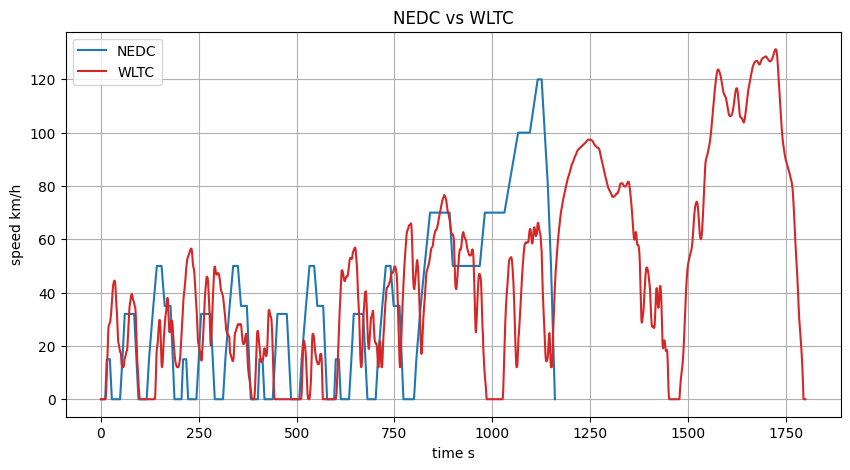

In [34]:
# Color plot 
r='#b7190f'
b='#26619c'
# Create a new figure
fig = plt.figure(figsize=(10,5))

plt.plot(NEDC.time,NEDC.kmph,label='NEDC',c='C0')
plt.plot(WLTC.time,WLTC.kmph,label='WLTC',c='C3')
plt.title('NEDC vs WLTC')
plt.xlabel('time s')
plt.ylabel('speed km/h')
plt.legend()
plt.grid()
#plt.savefig(r'../otherFiles/figures/NEDC_WLTC.png')
plt.show()

We can see that the WLTC is more realistic than the NEDC

# Simulation element tests

## Motor

In [35]:
mat = scipy.io.loadmat('../matlabFiles/testSubSystems/motor_test_res.mat')

**Torque vs speed**

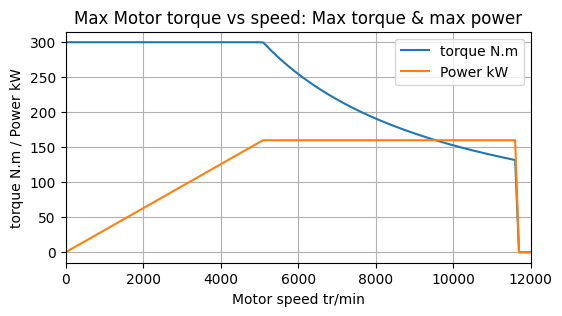

In [36]:
# motor speed rpm
motor_speed_rpmPM=mat['motor_speed_rpm']
motor_speed_rpmPM=motor_speed_rpmPM[0][0][1][0][0][0].flatten()

# motor torque
motor_torquePM=mat['motor_torque']
motor_torquePM=motor_torquePM[0][0][1][0][0][0].flatten()

# convert to dataFrame
dfm=pd.DataFrame(motor_speed_rpmPM,columns=['motor_speed_rpm'])
dfm['motor_torque']=motor_torquePM

# Power
powerKwPM=motor_torquePM*(motor_speed_rpmPM*2*np.pi/60)/1000


# Plot
figure(figsize=(6, 3))
plt.plot(motor_speed_rpmPM,motor_torquePM,label='torque N.m')
plt.plot(motor_speed_rpmPM,powerKwPM,label='Power kW')
plt.grid()
plt.ylabel('torque N.m / Power kW')
plt.xlabel('Motor speed tr/min')
plt.title('Max Motor torque vs speed: Max torque & max power')
plt.xlim([0,12000])
plt.legend()
plt.show()

For this simulation, we will use the simple strategy: max torque util the power reached its max, and after that the power will be limited to its max
<br> 
In the real control, the torque / speed is close to this cuve, but with a more complicated vector control strategy

**Comparaison between the torque of the electrical Megane-E 220Hp and the gasoline Volvo C30 T5 220Hp**

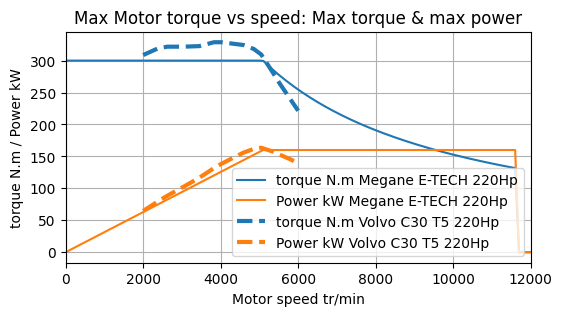

In [37]:
# The below data is extracted from the graph in the link below: 
# https://en.bsr.se/tuning-kits/t/947/volvo-c30-t5-220hp-2007-2013-b-5254-t3
volvo='''2000	308.7209302
2255.578093	315.6976744
2385.395538	319.1860465
2624.74645	321.8023256
3050.709939	321.8023256
3448.275862	322.6744186
3829.614604	328.7790698
4016.227181	328.7790698
4356.997972	326.1627907
4588.235294	324.4186047
4851.926978	318.3139535
5046.653144	309.5930233
5342.799189	281.6860465
5513.184584	265.1162791
5805.273834	238.9534884
6000	221.5116279'''
volvo=volvo.split('\n')
volvo=[x.split('\t') for x in volvo]
volvo=np.array(volvo).T.astype(float)
rpm_vol=volvo[0]
torq_vol=volvo[1]
power_vol=torq_vol*(rpm_vol *2*np.pi/60)/1000

# Plot
figure(figsize=(6, 3))
plt.plot(motor_speed_rpmPM,motor_torquePM,label='torque N.m Megane E-TECH 220Hp',c='C0')
plt.plot(motor_speed_rpmPM,powerKwPM,label='Power kW Megane E-TECH 220Hp',c='C1')

plt.plot(rpm_vol,torq_vol,linestyle="--",linewidth=3,\
         label='torque N.m Volvo C30 T5 220Hp',c='C0')
plt.plot(rpm_vol,power_vol,linestyle="--",linewidth=3,\
         label='Power kW Volvo C30 T5 220Hp',c='C1')

plt.grid()
plt.ylabel('torque N.m / Power kW')
plt.xlabel('Motor speed tr/min')
plt.title('Max Motor torque vs speed: Max torque & max power')
plt.xlim([0,12000])
plt.legend()
plt.show()

we can see that the Megane-E 220Hp and the gasoline Volvo C30 T5 220 Hp have the same peak power, but the speed range of the max torque is very short for the gasoline, because of that the conventional cars use a gearbox to adapt the speed, and the electrical vehicle use just a one level reductor.

## Battery

In [38]:
mat = scipy.io.loadmat('../matlabFiles/testSubSystems/battery_test_res.mat')

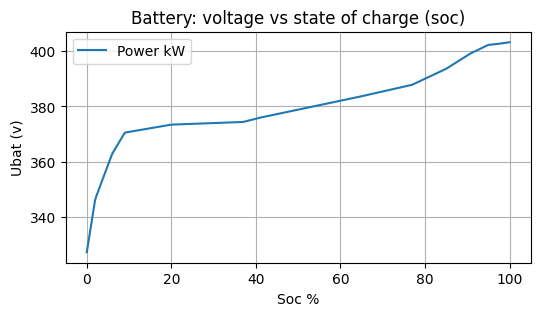

In [39]:
# battery Ubat
battery_Ubat=mat['battery_Ubat']
battery_Ubat=battery_Ubat[0][0][1][0][0][0].flatten()

# battery SOC
battery_soc=mat['battery_soc']
battery_soc=battery_soc[0][0][1][0][0][0].flatten()

# Plot
figure(figsize=(6, 3))
plt.plot(battery_soc,battery_Ubat,label='Power kW')
plt.grid()
plt.ylabel('Ubat (v)')
plt.xlabel('Soc %')
plt.title('Battery: voltage vs state of charge (soc)')
plt.legend()
plt.show()

## Body 

In [40]:
# read matlab data 
mat = scipy.io.loadmat('../matlabFiles/testSubSystems/body_test_res.mat')

**Plot**

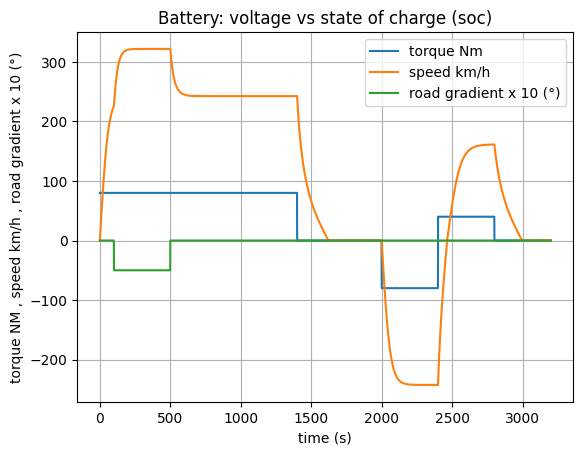

In [41]:
# time 
time  = mat['body_test_torque'][0][0][0].flatten()

# torque
body_test_torque=mat['body_test_torque']
body_test_torque=body_test_torque[0][0][1][0][0][0].flatten()

# speed 
body_test_speedMeas=mat['body_test_speedMeas']
body_test_speedMeas=body_test_speedMeas[0][0][1][0][0][0].flatten()

# speed 
body_test_roadGrad=mat['body_test_roadGrad']
body_test_roadGrad=180*body_test_roadGrad[0][0][1][0][0][0].flatten()/np.pi

plt.plot(time,body_test_torque,label='torque Nm')
plt.plot(time,body_test_speedMeas,label='speed km/h')
plt.plot(time,10*body_test_roadGrad,label='road gradient x 10 (°)')

plt.ylabel('torque NM , speed km/h , road gradient x 10 (°)')
plt.xlabel('time (s)')
plt.title('Battery: voltage vs state of charge (soc)')
plt.grid()
plt.legend()
plt.show()

## PI regulator, speed controller 

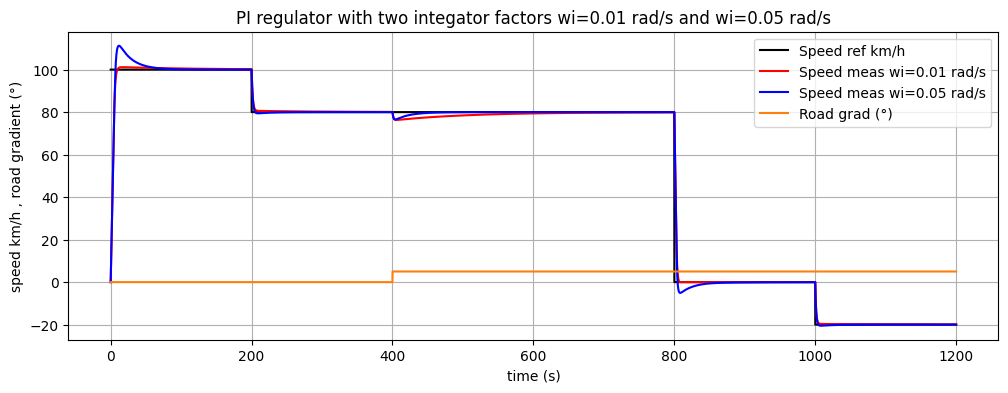

In [42]:
# read matlab data for wi=0.01 rad/s
mat = scipy.io.loadmat('../matlabFiles/testSubSystems/pi_regulator_wi_0.01.mat')


# time 
time  = mat['reg_kmph_ref'][0][0][0].flatten()

# road gradient
road_grad  = 180*mat['road_grad'][0][0][1][0][0][0].flatten()/np.pi

# Speed ref
reg_kmph_ref=mat['reg_kmph_ref'][0][0][1][0][0][0].flatten()

# speed measurement for wi=0.01 rad/s
reg_kmph_meas_w0_01=mat['reg_kmph_meas'][0][0][1][0][0][0].flatten()

# read matlab data for wi=0.01 rad/s
mat = scipy.io.loadmat('../matlabFiles/testSubSystems/pi_regulator_wi_0.05.mat')

# speed measurement for wi=0.05 rad/s
reg_kmph_meas_w0_05=mat['reg_kmph_meas'][0][0][1][0][0][0].flatten()

# the regulator output 
reg_pi_output=mat['reg_pi_output'][0][0][1][0][0][0].flatten()

# Plot
figure(figsize=(12, 4))
plt.plot(time,reg_kmph_ref,label='Speed ref km/h',c='k')
plt.plot(time,reg_kmph_meas_w0_01,label='Speed meas wi=0.01 rad/s',c='r')
plt.plot(time,reg_kmph_meas_w0_05,label='Speed meas wi=0.05 rad/s',c='b')
plt.plot(time,road_grad,label='Road grad (°)',c='C1')
#plt.plot(time,20*reg_pi_output,label='regulator output',c='g')

plt.ylabel('speed km/h , road gradient (°)')
plt.xlabel('time (s)')
plt.title('PI regulator with two integator factors wi=0.01 rad/s and wi=0.05 rad/s')
plt.grid()
plt.legend()
plt.show()

We will conserve the integrator parameter wi=0.05 rad/s, because it give a best result in WLTC cycle. 
<br>
in fact, in the real life we can use the soft start, we can use reference with a sloop and not a perfect step 

# Driving simulation WLTC / NEDC/ Heighway ...

In [43]:
# This dictionary will be used to store autonomy of each cycle/driving
dic_auto={}

## WLTC Cycle

**Read the matlab/simulink results**

In [44]:
mat = scipy.io.loadmat('../matlabFiles/WLTC/WLTC_results.mat')

**Select only variables that start with 'tws_...'**

In [45]:
cols=[x for x in mat.keys() if 'tws_' in x]

**Convert the selectionned variables to a dataFrame**

In [46]:
# Convert the selectionned variables to a dataFrame
c=cols[0]
# the time
time  = mat[c][0][0][0].flatten()
dfwltc=pd.DataFrame(time,columns=['time'])
# the other variables 
for c in cols:
    value = mat[c][0][0][1][0][0][0].flatten()
    dfwltc[c]=value
    
# Display the head of the DF
dfwltc.head(2)

time  tws_I_bat_ev  tws_Power_AC_ev  tws_Power_DC_ev  tws_Power_meca_ev   
0   0.0           0.0              0.0              0.0                0.0  \
1   0.5           0.0              0.0              0.0                0.0   

   tws_Power_wheel_ev  tws_Ubat_ev  tws_acceleration_break   
0                 0.0        403.2                     0.0  \
1                 0.0        403.2                     0.0   

   tws_acceleration_ev  tws_battery_power  ...  tws_kmph_meas  tws_kmph_ref   
0                  0.0        216000000.0  ...            0.0           0.0  \
1                  0.0        216000000.0  ...            0.0           0.0   

   tws_loss_INV_ev  tws_loss_batt_ev  tws_loss_body_ev  tws_loss_motor_ev   
0              0.0               0.0               0.0                0.0  \
1              0.0               0.0               0.0                0.0   

   tws_road_grad  tws_soc_ev  tws_time  tws_torque_motor_ev  
0              0       100.0       0.0                  0.0  
1              0       100.0       0.5                  0.0  

[2 rows x 21 columns]

**Plot the speed: ref and measurement**

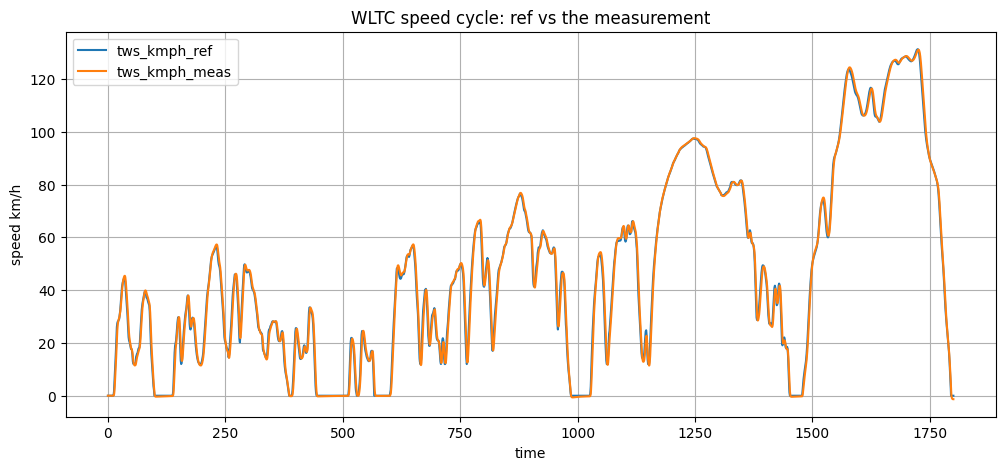

In [47]:
dfwltc.plot(x='time', y=['tws_kmph_ref','tws_kmph_meas'],figsize=(12, 5))
plt.grid()
plt.ylabel('speed km/h')
plt.title('WLTC speed cycle: ref vs the measurement')
plt.show()

**Plot the different powers**

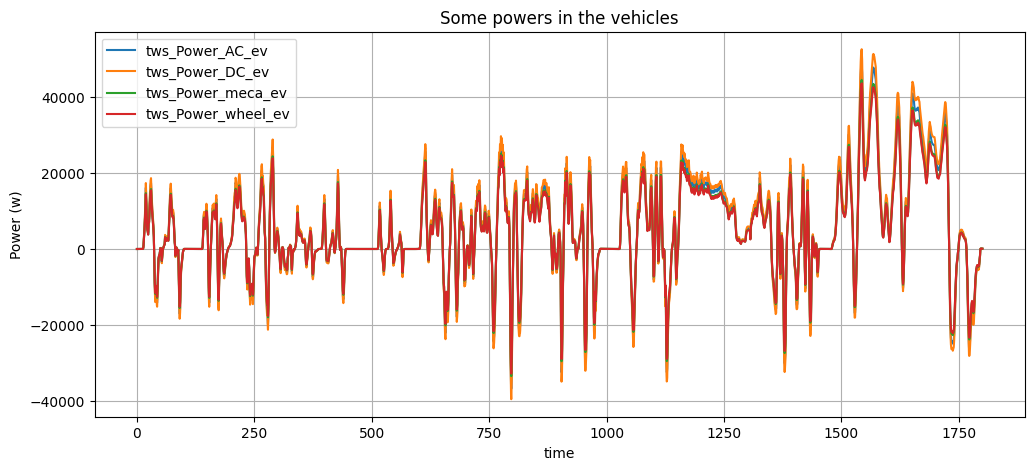

In [48]:
dfwltc.plot(x='time', y=['tws_Power_AC_ev', 'tws_Power_DC_ev',
       'tws_Power_meca_ev', 'tws_Power_wheel_ev'],figsize=(12, 5))
plt.grid()
plt.ylabel('Power (w)')
plt.title('Some powers in the vehicles')
plt.show()

**Change some errors in the nomination of the columns**

In [49]:
dfwltc.rename({'tws_battery_power': 'tws_battery_energy_j',
              'rmp_2_kmph':'rpm_2_kmph'},axis=1,inplace=True)

**Plot the different losses**

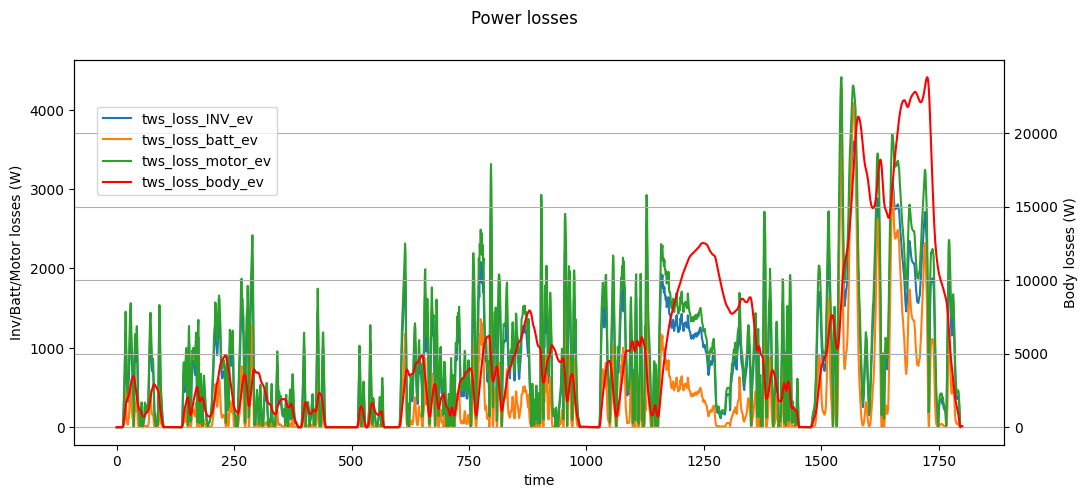

In [50]:
# Create a new figure with two y-axes
fig, ax1 = plt.subplots(figsize=(5,3))
ax2 = ax1.twinx()


# AX1 
dfwltc.plot(x='time', y=['tws_loss_INV_ev',
                    'tws_loss_batt_ev', 
                    'tws_loss_motor_ev'],figsize=(12, 5),
           ax=ax1)
ax1.set_ylabel('Inv/Batt/Motor losses (W)')

# AX2
dfwltc.plot(x='time', y=['tws_loss_body_ev'],
           ax=ax2,c='r')
ax2.set_ylabel('Body losses (W)')

# GENERAL SETTINGS
plt.suptitle('Power losses' )
ax1.legend().set_visible(False)
ax2.legend().set_visible(False)
fig.legend(loc='upper right', bbox_to_anchor=(0.3, 0.8))
plt.grid()
plt.show()

**Plot the covered distance**

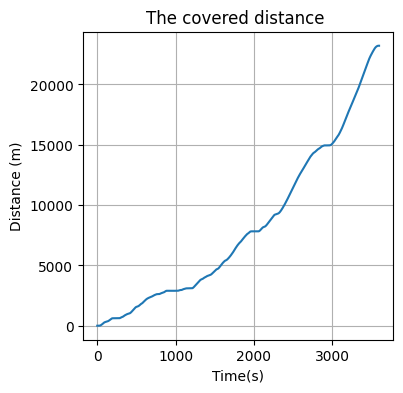

In [51]:
dfwltc[ 'tws_distance_ev'].plot(figsize=(4, 4))
plt.grid()
plt.ylabel('Distance (m)')
plt.xlabel('Time(s)')
plt.title('The covered distance ')
plt.show()

**The autonomy of this simulation**

In [52]:
delta_soc=dfwltc['tws_soc_ev'].iloc[0]-dfwltc['tws_soc_ev'].iloc[-1]
delta_dist=dfwltc['tws_distance_ev'].iloc[-1]-dfwltc[ 'tws_distance_ev'].iloc[0]
autonomy = 100*delta_dist/(delta_soc*1000)
matlab_auto=mat['autonomy'].item()
print('The autonomy of the WLTC cycle is: ','{:.2f}'.format(autonomy),'km')
print('The autonomy calculated by matlab is: ',  '{:.2f}'.format(matlab_auto),'km')

The autonomy of the WLTC cycle is:  456.96 km
The autonomy calculated by matlab is:  456.99 km


In [53]:
# Store the autonomy in the dic_auto dictionary
dic_auto['wltc']=autonomy

**Calculate the RPM**

In [54]:
rpm_2_kmph=mat['rmp_2_kmph'].item()
dfwltc['tws_rpm']=dfwltc['tws_kmph_meas']/rpm_2_kmph

**Plot the RPM / torque**

In [55]:
x=motor_speed_rpmPM.tolist()
xPM=x+x
yPM=motor_torquePM.tolist()+(-motor_torquePM).tolist()

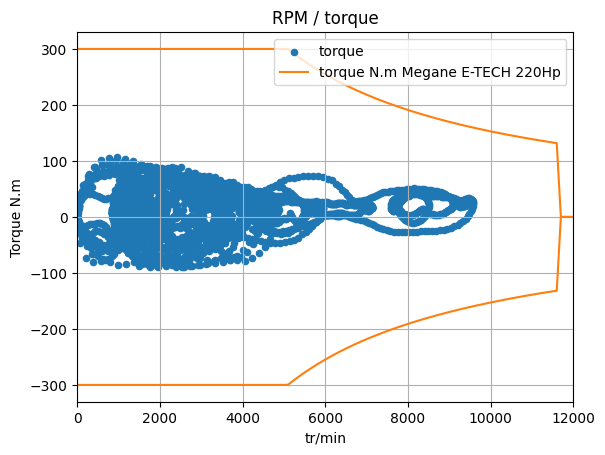

In [56]:
dfwltc.plot(x='tws_rpm',y='tws_torque_motor_ev',kind='scatter',c='C0',label='torque')
plt.plot(motor_speed_rpmPM,motor_torquePM,label='torque N.m Megane E-TECH 220Hp',c='C1')
plt.plot(motor_speed_rpmPM,-motor_torquePM,c='C1')
plt.xlim([0,12000])
plt.grid()
plt.legend()
plt.xlabel('tr/min')
plt.ylabel('Torque N.m')
plt.title('RPM / torque')
plt.show()

In [57]:
dfwltc=dfwltc.astype('float32')

## NEDC Cycle

**Read the matlab/simulink results**

In [58]:
mat = scipy.io.loadmat('../matlabFiles/NEDC/nedc.mat')

**Select only variables that start with 'tws_...'**

In [59]:
cols=[x for x in mat.keys() if 'tws_' in x]

**Convert the selectionned variables to a dataFrame**

In [60]:
# Convert the selectionned variables to a dataFrame
c=cols[0]
# the time
time  = mat[c][0][0][0].flatten()
dfNEDC=pd.DataFrame(time,columns=['time'])
# the other variables 
for c in cols:
    value = mat[c][0][0][1][0][0][0].flatten()
    dfNEDC[c]=value
    
# Display the head of the DF
dfNEDC.head(2)

time  tws_I_bat_ev  tws_Power_AC_ev  tws_Power_DC_ev  tws_Power_meca_ev   
0   0.0           0.0              0.0              0.0                0.0  \
1   0.5           0.0              0.0              0.0                0.0   

   tws_Power_wheel_ev  tws_Ubat_ev  tws_acceleration_break   
0                 0.0        403.2                     0.0  \
1                 0.0        403.2                     0.0   

   tws_acceleration_ev  tws_battery_power  ...  tws_kmph_meas  tws_kmph_ref   
0                  0.0        216000000.0  ...            0.0           0.0  \
1                  0.0        216000000.0  ...            0.0           0.0   

   tws_loss_INV_ev  tws_loss_batt_ev  tws_loss_body_ev  tws_loss_motor_ev   
0              0.0               0.0               0.0                0.0  \
1              0.0               0.0               0.0                0.0   

   tws_road_grad  tws_soc_ev  tws_time  tws_torque_motor_ev  
0              0       100.0       0.0                  0.0  
1              0       100.0       0.5                  0.0  

[2 rows x 21 columns]

**Plot the speed: ref and measurement**

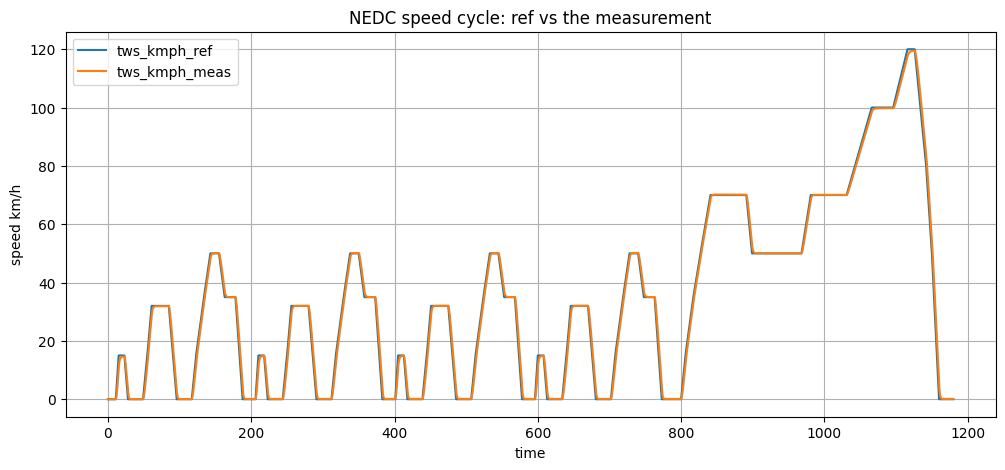

In [61]:
dfNEDC.plot(x='time', y=['tws_kmph_ref','tws_kmph_meas'],figsize=(12, 5))
plt.grid()
plt.ylabel('speed km/h')
plt.title('NEDC speed cycle: ref vs the measurement')
plt.show()

**Plot the different powers**

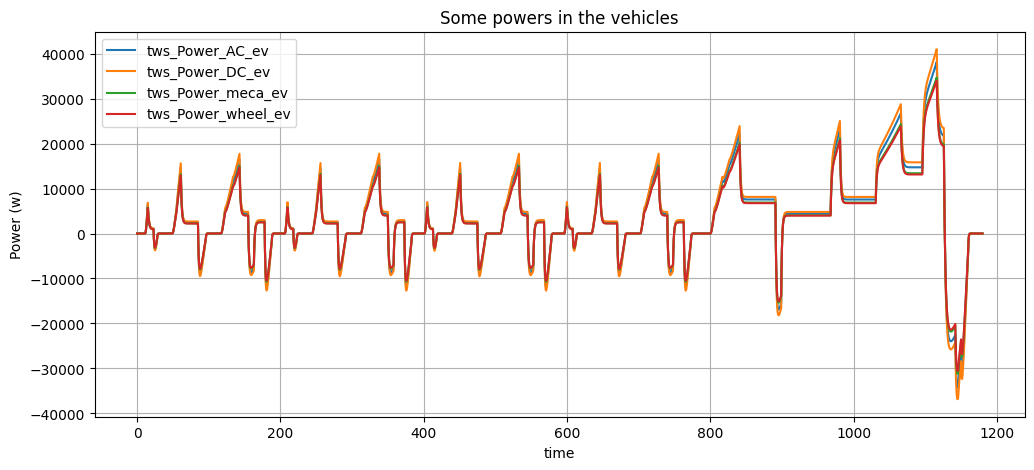

In [62]:
dfNEDC.plot(x='time', y=['tws_Power_AC_ev', 'tws_Power_DC_ev',
       'tws_Power_meca_ev', 'tws_Power_wheel_ev'],figsize=(12, 5))
plt.grid()
plt.ylabel('Power (w)')
plt.title('Some powers in the vehicles')
plt.show()

**Change some errors in the nomination of the columns**

In [63]:
dfNEDC.rename({'tws_battery_power': 'tws_battery_energy_j',
              'rmp_2_kmph':'rpm_2_kmph'},axis=1,inplace=True)

**Plot the different losses**

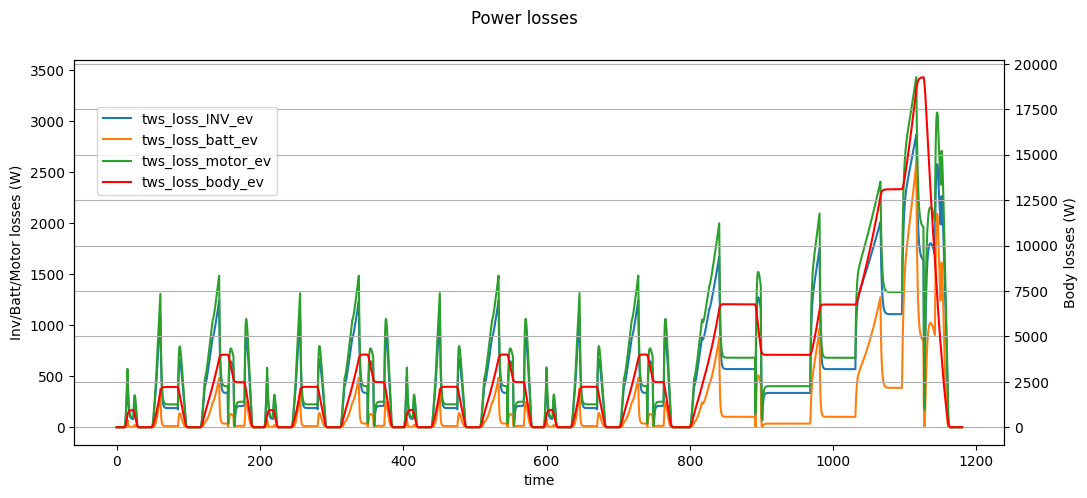

In [64]:
# Create a new figure with two y-axes
fig, ax1 = plt.subplots(figsize=(5,3))
ax2 = ax1.twinx()


# AX1 
dfNEDC.plot(x='time', y=['tws_loss_INV_ev',
                    'tws_loss_batt_ev', 
                    'tws_loss_motor_ev'],figsize=(12, 5),
           ax=ax1)
ax1.set_ylabel('Inv/Batt/Motor losses (W)')

# AX2
dfNEDC.plot(x='time', y=['tws_loss_body_ev'],
           ax=ax2,c='r')
ax2.set_ylabel('Body losses (W)')

# GENERAL SETTINGS
plt.suptitle('Power losses' )
ax1.legend().set_visible(False)
ax2.legend().set_visible(False)
fig.legend(loc='upper right', bbox_to_anchor=(0.3, 0.8))
plt.grid()
plt.show()

**Plot the covered distance**

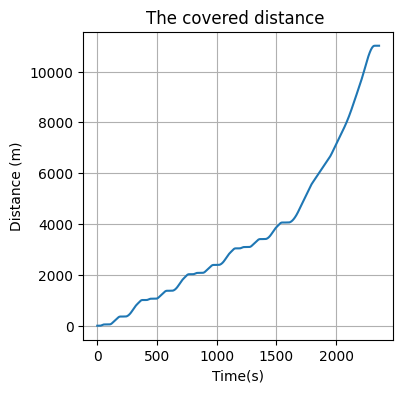

In [65]:
dfNEDC[ 'tws_distance_ev'].plot(figsize=(4, 4))
plt.grid()
plt.ylabel('Distance (m)')
plt.xlabel('Time(s)')
plt.title('The covered distance ')
plt.show()

**The autonomy of this simulation**

In [66]:
delta_soc=dfNEDC['tws_soc_ev'].iloc[0]-dfNEDC['tws_soc_ev'].iloc[-1]
delta_dist=dfNEDC['tws_distance_ev'].iloc[-1]-dfNEDC[ 'tws_distance_ev'].iloc[0]
autonomy = 100*delta_dist/(delta_soc*1000)
matlab_auto=mat['autonomy'].item()
print('The autonomy of the NEDC cycle is: ','{:.2f}'.format(autonomy),'km')
print('The autonomy calculated by matlab is: ',  '{:.2f}'.format(matlab_auto),'km')

The autonomy of the NEDC cycle is:  525.38 km
The autonomy calculated by matlab is:  525.38 km


In [67]:
# Store the autonomy in the dic_auto dictionary
dic_auto['nedc']=autonomy

**Calculate the RPM**

In [68]:
rpm_2_kmph=mat['rmp_2_kmph'].item()
dfNEDC['tws_rpm']=dfNEDC['tws_kmph_meas']/rpm_2_kmph

**Plot the RPM / torque**

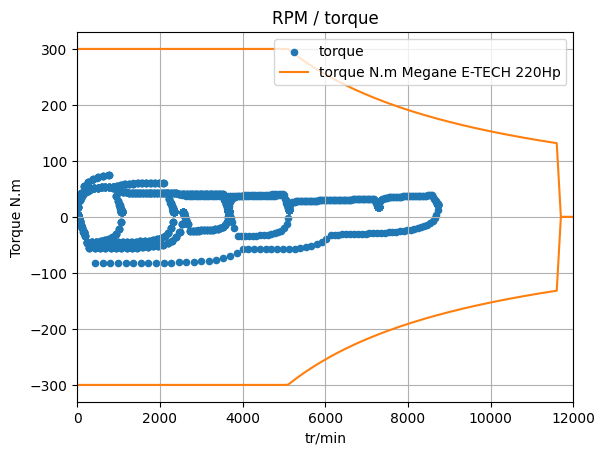

In [69]:
dfNEDC.plot(x='tws_rpm',y='tws_torque_motor_ev',kind='scatter',c='C0',label='torque')
plt.plot(motor_speed_rpmPM,motor_torquePM,label='torque N.m Megane E-TECH 220Hp',c='C1')
plt.plot(motor_speed_rpmPM,-motor_torquePM,c='C1')
plt.xlim([0,12000])
plt.grid()
plt.xlabel('tr/min')
plt.ylabel('Torque N.m')
plt.title('RPM / torque')
plt.legend()
plt.show()

In [70]:
dfNEDC=dfNEDC.astype('float32')

## Paris heigh way A5 225km

**Read the matlab/simulink results**

In [71]:
mat = scipy.io.loadmat('../matlabFiles/ParisA5_225km/parisA5_results.mat')

**Select only variables that start with 'tws_...'**

In [72]:
cols=[x for x in mat.keys() if 'tws_' in x]

**Convert the selectionned variables to a dataFrame**

In [73]:
# Convert the selectionned variables to a dataFrame
c=cols[0]
# the time
time  = mat[c][0][0][0].flatten()
dfA5=pd.DataFrame(time,columns=['time'])
# the other variables 
for c in cols:
    value = mat[c][0][0][1][0][0][0].flatten()
    dfA5[c]=value
    
# Display the head of the DF
dfA5.head(2)

time  tws_I_bat_ev  tws_Power_AC_ev  tws_Power_DC_ev  tws_Power_meca_ev   
0   0.0      0.000000         0.000000         0.000000            0.00000  \
1   0.5      2.290319       858.814692       923.456658          781.52137   

   tws_Power_wheel_ev  tws_Ubat_ev  tws_acceleration_break   
0            0.000000   403.200000                0.262368  \
1          765.890942   403.199971                0.198392   

   tws_acceleration_ev  tws_battery_power  ...  tws_kmph_meas  tws_kmph_ref   
0             1.206972       2.160000e+08  ...       0.000000      5.247364  \
1             0.785154       2.159997e+08  ...       1.716509      5.661534   

   tws_loss_INV_ev  tws_loss_batt_ev  tws_loss_body_ev  tws_loss_motor_ev   
0         0.000000          0.000000          0.000000           0.000000  \
1        64.641966          1.311391        107.003959          77.293322   

   tws_road_grad  tws_soc_ev  tws_time  tws_torque_motor_ev  
0            0.0  100.000000       0.0            78.710461  
1            0.0   99.999877       0.5            59.517665  

[2 rows x 21 columns]

**Plot the speed: ref and measurement**

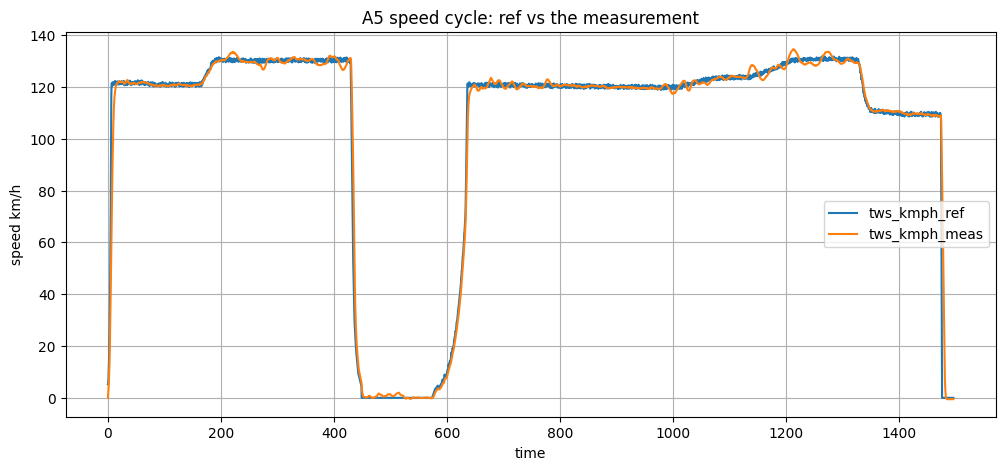

In [74]:
dfA5.plot(x='time', y=['tws_kmph_ref','tws_kmph_meas'],figsize=(12, 5))
plt.grid()
plt.ylabel('speed km/h')
plt.title('A5 speed cycle: ref vs the measurement')
plt.show()

**Plot the different powers**

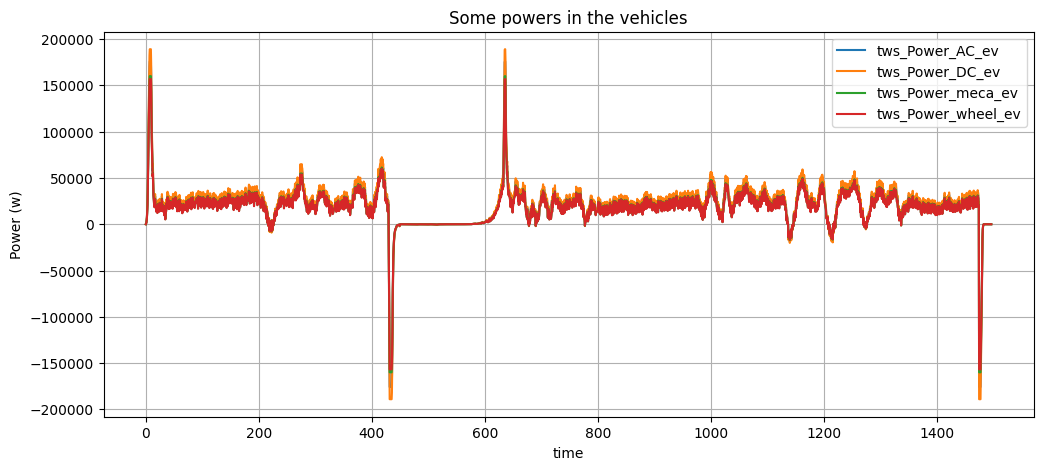

In [75]:
dfA5.plot(x='time', y=['tws_Power_AC_ev', 'tws_Power_DC_ev',
       'tws_Power_meca_ev', 'tws_Power_wheel_ev'],figsize=(12, 5))
plt.grid()
plt.ylabel('Power (w)')
plt.title('Some powers in the vehicles')
plt.show()

**Change some errors in the nomination of the columns**

In [76]:
dfA5.rename({'tws_battery_power': 'tws_battery_energy_j',
              'rmp_2_kmph':'rpm_2_kmph'},axis=1,inplace=True)

**Plot the different losses**

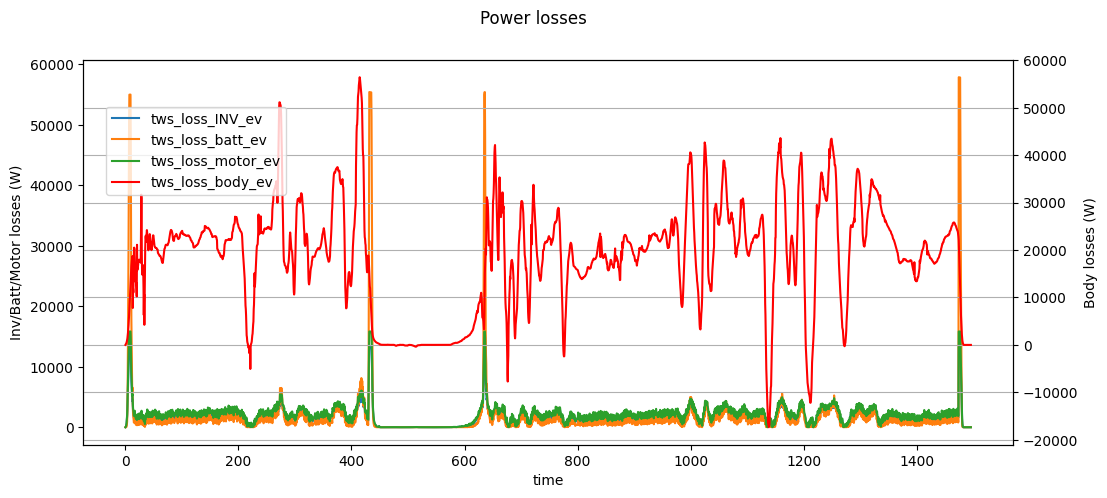

In [77]:
# Create a new figure with two y-axes
fig, ax1 = plt.subplots(figsize=(5,3))
ax2 = ax1.twinx()


# AX1 
dfA5.plot(x='time', y=['tws_loss_INV_ev',
                    'tws_loss_batt_ev', 
                    'tws_loss_motor_ev'],figsize=(12, 5),
           ax=ax1)
ax1.set_ylabel('Inv/Batt/Motor losses (W)')

# AX2
dfA5.plot(x='time', y=['tws_loss_body_ev'],
           ax=ax2,c='r')
ax2.set_ylabel('Body losses (W)')

# GENERAL SETTINGS
plt.suptitle('Power losses' )
ax1.legend().set_visible(False)
ax2.legend().set_visible(False)
fig.legend(loc='upper right', bbox_to_anchor=(0.3, 0.8))
plt.grid()
plt.show()

**Plot the covered distance**

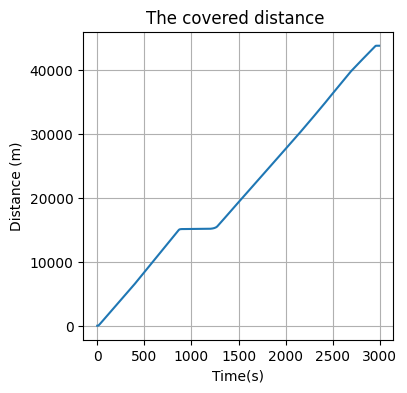

In [78]:
dfA5[ 'tws_distance_ev'].plot(figsize=(4, 4))
plt.grid()
plt.ylabel('Distance (m)')
plt.xlabel('Time(s)')
plt.title('The covered distance ')
plt.show()

**The autonomy of this simulation**

In [79]:
delta_soc=dfA5['tws_soc_ev'].iloc[0]-dfA5['tws_soc_ev'].iloc[-1]
delta_dist=dfA5['tws_distance_ev'].iloc[-1]-dfA5[ 'tws_distance_ev'].iloc[0]
autonomy = 100*delta_dist/(delta_soc*1000)
matlab_auto=mat['autonomy'].item()
print('The autonomy of the A5 cycle is: ','{:.2f}'.format(autonomy),'km')
print('The autonomy calculated by matlab is: ',  '{:.2f}'.format(matlab_auto),'km')

The autonomy of the A5 cycle is:  283.14 km
The autonomy calculated by matlab is:  283.15 km


In [80]:
# Store the autonomy in the dic_auto dictionary
dic_auto['highway']=autonomy

**Calculate the RPM**

In [81]:
rpm_2_kmph=mat['rmp_2_kmph'].item()
dfA5['tws_rpm']=dfA5['tws_kmph_meas']/rpm_2_kmph

**Plot the RPM / torque**

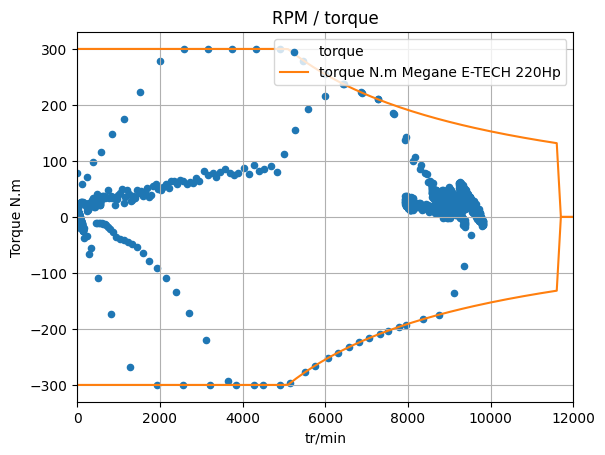

In [82]:
dfA5.plot(x='tws_rpm',y='tws_torque_motor_ev',kind='scatter',c='C0',label='torque')
plt.plot(motor_speed_rpmPM,motor_torquePM,label='torque N.m Megane E-TECH 220Hp',c='C1')
plt.plot(motor_speed_rpmPM,-motor_torquePM,c='C1')
plt.legend()
plt.xlim([0,12000])
plt.grid()
plt.xlabel('tr/min')
plt.ylabel('Torque N.m')
plt.title('RPM / torque')
plt.show()

In [83]:
dfA5=dfA5.astype('float32')

## The impact of speed on autonomy

**Read the matlab/simulink results**

In [84]:
mat = scipy.io.loadmat('../matlabFiles/speed_autonomy/speed_auto_results.mat')

**Select only variables that start with 'tws_...'**

In [85]:
cols=[x for x in mat.keys() if 'tws_' in x]

**Convert the selectionned variables to a dataFrame**

In [86]:
# Convert the selectionned variables to a dataFrame
c=cols[0]
# the time
time  = mat[c][0][0][0].flatten()
dfkmph_step=pd.DataFrame(time,columns=['time'])
# the other variables 
for c in cols:
    value = mat[c][0][0][1][0][0][0].flatten()
    dfkmph_step[c]=value
    
# Display the head of the DF
dfkmph_step.head(2)

time  tws_I_bat_ev  tws_Power_AC_ev  tws_Power_DC_ev  tws_Power_meca_ev   
0   0.0      0.000000         0.000000         0.000000           0.000000  \
1   0.5     54.486782     20431.204693     21969.037305       18592.396271   

   tws_Power_wheel_ev  tws_Ubat_ev  tws_acceleration_break   
0            0.000000   403.200000                     1.0  \
1        18220.548345   403.199388                     1.0   

   tws_acceleration_ev  tws_battery_energy  ...  tws_kmph_meas  tws_kmph_ref   
0             4.600298        2.160000e+08  ...       0.000000            30  \
1             4.471882        2.159945e+08  ...       8.101497            30   

   tws_loss_INV_ev  tws_loss_batt_ev  tws_loss_body_ev  tws_loss_motor_ev   
0         0.000000          0.000000          0.000000           0.000000  \
1      1537.832611        742.202364        508.623705        1838.808422   

   tws_road_grad  tws_soc_ev  tws_time  tws_torque_motor_ev  
0              0  100.000000       0.0                300.0  
1              0   99.997449       0.5                300.0  

[2 rows x 21 columns]

**Plot the speed: ref and measurement**

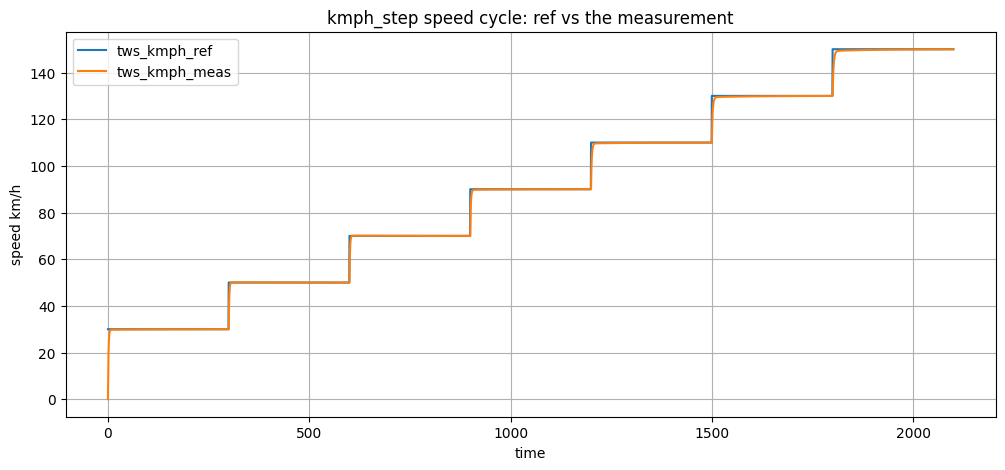

In [87]:
dfkmph_step.plot(x='time', y=['tws_kmph_ref','tws_kmph_meas'],figsize=(12, 5))
plt.grid()
plt.ylabel('speed km/h')
plt.title('kmph_step speed cycle: ref vs the measurement')
plt.show()

**Change some errors in the nomination of the columns**

In [88]:
dfkmph_step.rename({'tws_battery_power': 'tws_battery_energy_j',
              'rmp_2_kmph':'rpm_2_kmph'},axis=1,inplace=True)

**Plot the covered distance**

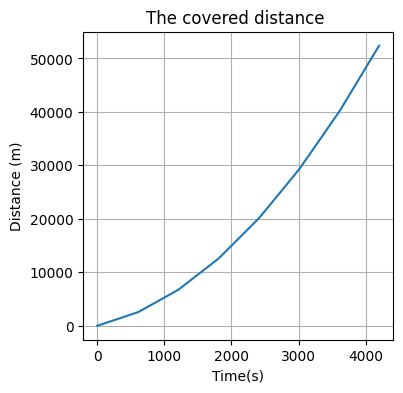

In [89]:
dfkmph_step[ 'tws_distance_ev'].plot(figsize=(4, 4))
plt.grid()
plt.ylabel('Distance (m)')
plt.xlabel('Time(s)')
plt.title('The covered distance ')
plt.show()

**Calculate the RPM**

In [90]:
rpm_2_kmph=mat['rmp_2_kmph'].item()
dfkmph_step['tws_rpm']=dfkmph_step['tws_kmph_meas']/rpm_2_kmph

**Plot the RPM / torque**

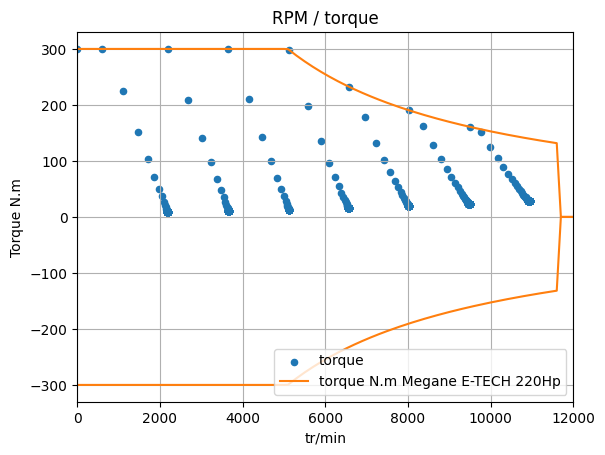

In [91]:
dfkmph_step.plot(x='tws_rpm',y='tws_torque_motor_ev',kind='scatter',c='C0',label='torque')
plt.plot(motor_speed_rpmPM,motor_torquePM,label='torque N.m Megane E-TECH 220Hp',c='C1')
plt.plot(motor_speed_rpmPM,-motor_torquePM,c='C1')
plt.legend()
plt.xlim([0,12000])
plt.grid()
plt.xlabel('tr/min')
plt.ylabel('Torque N.m')
plt.title('RPM / torque')
plt.show()

**Calculate autonomy by speed**

In [92]:
# - speed_step: Step size for speed calculations
speed_step=mat['speed_step'][0][0]
# - sim_time: Total simulation time
sim_time=mat['sim_time'][0][0]
# - Ts: Time step
Ts=mat['Ts'][0][0]
# - n_step: Number of simulation steps
n_step=int(sim_time/(speed_step*Ts))
# - i: Index for iteration
i=int(0.98*speed_step/Ts)
# - di: Index for delta calculations
di=int(0.5*speed_step/Ts)

speed_step, sim_time,Ts, n_step,i,di
auto_list = []  

# List to store results
while i < sim_time / Ts:
    # Calculate change in state of charge (delta_soc)
    delta_soc = dfkmph_step.loc[i - di : i, 'tws_soc_ev']
    delta_soc = delta_soc.iloc[0] - delta_soc.iloc[-1]

    # Calculate change in distance (delta_dist)
    delta_dist = dfkmph_step.loc[i - di : i, 'tws_distance_ev']
    delta_dist = delta_dist.iloc[-1] - delta_dist.iloc[0]

    # Calculate autonomy (distance covered per unit SOC)
    autonomy = 100 * delta_dist / (delta_soc * 1000)

    # Calculate average speed (kmph)
    kmph = dfkmph_step.loc[i - di : i, 'tws_kmph_meas'].mean()

    # Append results to the auto_list
    auto_list.append({"kmph": kmph, "autonomy": autonomy})
    i += int(speed_step / Ts)


In [93]:
dfauto=pd.DataFrame(auto_list)#.plot.bar(x='kmph',y='autonomy')
dfauto.kmph= (dfauto.kmph+0.5).astype(int)
dfauto

kmph    autonomy
0    30  725.536021
1    50  624.870433
2    70  516.899120
3    90  420.116752
4   110  340.486424
5   130  277.409475
6   150  228.123454

In [94]:
for i in range(len(dfauto)):
    kmph=dfauto.loc[i,'kmph']
    autonomy=dfauto.loc[i,'autonomy']
    dic_auto[str(kmph)+'km/h']=autonomy

**Plot the autonomy vs speed**

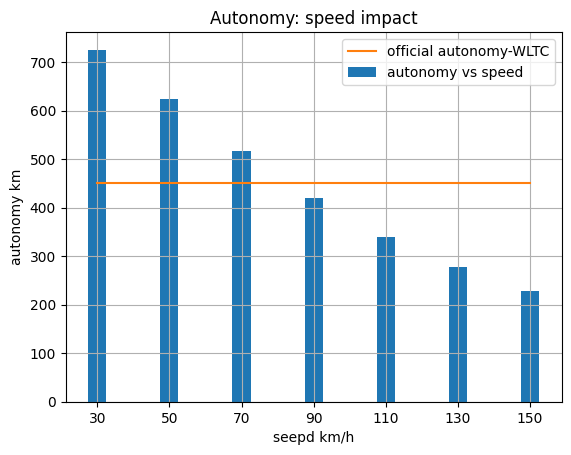

In [95]:
plt.bar(dfauto.kmph,dfauto.autonomy,width=5,label='autonomy vs speed')
# AUTO 450 # https://cdn.group.renault.com/ren/fr/product-plans/brochures/megane-e-tech-electrique/brochure-megane-electrique.pdf.asset.pdf/6614df6f13.pdf
plt.plot([30,150],[450,450],c='C1',label='official autonomy-WLTC')

plt.xticks(range(30,160,20))
plt.legend()
plt.grid()
plt.ylabel('autonomy km')
plt.xlabel('seepd km/h')
plt.title('Autonomy: speed impact')
plt.show()

plt.show()

In [96]:
dfkmph_step=dfkmph_step.astype('float32')

## Comparaison

In [97]:
# Dcitonary to dataFrame
dic_auto_s=pd.Series(dic_auto)

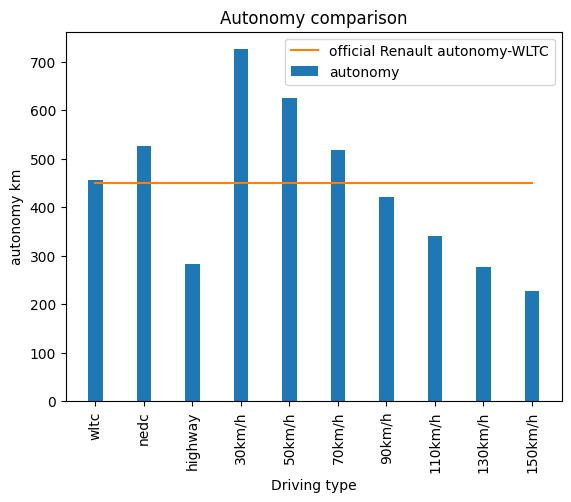

In [98]:
# Bar plot

plt.bar(dic_auto_s.index,dic_auto_s.values,width=0.3,label='autonomy')

# AUTO 450 # https://cdn.group.renault.com/ren/fr/product-plans/brochures/megane-e-tech-electrique/brochure-megane-electrique.pdf.asset.pdf/6614df6f13.pdf
n=len(dic_auto_s.index)
plt.plot([450]*n,c='C1',label='official Renault autonomy-WLTC')

plt.xticks(dic_auto_s.index)
plt.legend()
#plt.grid()
plt.ylabel('autonomy km')
plt.xlabel('Driving type')
plt.title('Autonomy comparison')
plt.xticks(rotation=90)
plt.show()

We can see that the autonomy depend a lot of the speed of the vehicle, in general a high speed reduce the autonomy of an electric car.
<br> 
This can be explained by the fact of the cubic relation between the drag loss and car speed.
<br> 
In general, an electrical car is good for the city uses, but not in the highway uses 

## Save the data

**drop the duplicated columns**

In [99]:
listdf=[dfwltc, dfNEDC, dfA5 ,dfkmph_step]

for df in listdf:
    #the time column is duplicated: 'time' and 'tws_time' 
    df.drop('time',axis=1,inplace=True)

**Rename columns**

In [100]:
dfwltc.columns

Index(['tws_I_bat_ev', 'tws_Power_AC_ev', 'tws_Power_DC_ev',
       'tws_Power_meca_ev', 'tws_Power_wheel_ev', 'tws_Ubat_ev',
       'tws_acceleration_break', 'tws_acceleration_ev', 'tws_battery_energy_j',
       'tws_distance_ev', 'tws_kmph_meas', 'tws_kmph_ref', 'tws_loss_INV_ev',
       'tws_loss_batt_ev', 'tws_loss_body_ev', 'tws_loss_motor_ev',
       'tws_road_grad', 'tws_soc_ev', 'tws_time', 'tws_torque_motor_ev',
       'tws_rpm'],
      dtype='object')

In [101]:
cols=dfwltc.columns
newcols=[x.replace('tws_','') for x in cols]
dic_cols={x:y for (x,y) in zip(cols, newcols)}
print(dic_cols)

{'tws_I_bat_ev': 'I_bat_ev', 'tws_Power_AC_ev': 'Power_AC_ev', 'tws_Power_DC_ev': 'Power_DC_ev', 'tws_Power_meca_ev': 'Power_meca_ev', 'tws_Power_wheel_ev': 'Power_wheel_ev', 'tws_Ubat_ev': 'Ubat_ev', 'tws_acceleration_break': 'acceleration_break', 'tws_acceleration_ev': 'acceleration_ev', 'tws_battery_energy_j': 'battery_energy_j', 'tws_distance_ev': 'distance_ev', 'tws_kmph_meas': 'kmph_meas', 'tws_kmph_ref': 'kmph_ref', 'tws_loss_INV_ev': 'loss_INV_ev', 'tws_loss_batt_ev': 'loss_batt_ev', 'tws_loss_body_ev': 'loss_body_ev', 'tws_loss_motor_ev': 'loss_motor_ev', 'tws_road_grad': 'road_grad', 'tws_soc_ev': 'soc_ev', 'tws_time': 'time', 'tws_torque_motor_ev': 'torque_motor_ev', 'tws_rpm': 'rpm'}


In [102]:
for df in listdf:
    df.rename(dic_cols,axis=1,inplace=True)

In [103]:
dfwltc.columns

Index(['I_bat_ev', 'Power_AC_ev', 'Power_DC_ev', 'Power_meca_ev',
       'Power_wheel_ev', 'Ubat_ev', 'acceleration_break', 'acceleration_ev',
       'battery_energy_j', 'distance_ev', 'kmph_meas', 'kmph_ref',
       'loss_INV_ev', 'loss_batt_ev', 'loss_body_ev', 'loss_motor_ev',
       'road_grad', 'soc_ev', 'time', 'torque_motor_ev', 'rpm'],
      dtype='object')

**add session ID**

In [104]:
sessions=['WLTC', 'NEDC','Highway' ,'speed_steps']
for (df,s) in zip(listdf,sessions):
    df['session']=s

**Concatenate the 4 dataFrame**

In [105]:
df=pd.concat(listdf,axis=0).reset_index(drop=True)
df.head(2)

I_bat_ev  Power_AC_ev  Power_DC_ev  Power_meca_ev  Power_wheel_ev   
0       0.0          0.0          0.0            0.0             0.0  \
1       0.0          0.0          0.0            0.0             0.0   

      Ubat_ev  acceleration_break  acceleration_ev  battery_energy_j   
0  403.200012                 0.0              0.0       216000000.0  \
1  403.200012                 0.0              0.0       216000000.0   

   distance_ev  ...  loss_batt_ev  loss_body_ev  loss_motor_ev  road_grad   
0          0.0  ...           0.0           0.0            0.0        0.0  \
1          0.0  ...           0.0           0.0            0.0        0.0   

   soc_ev  time  torque_motor_ev  rpm  session  tws_battery_energy  
0   100.0   0.0              0.0  0.0     WLTC                 NaN  
1   100.0   0.5              0.0  0.0     WLTC                 NaN  

[2 rows x 23 columns]

In [106]:
df.shape

(13156, 23)

**Correct the battery energy**

In [107]:
df.drop(['tws_battery_energy', 'battery_energy_j'],axis=1,inplace=True)

In [108]:
bat_energy_kwh=mat['bat_energy_kwh'].item()
df['bat_energy_kwh']=df.soc_ev*bat_energy_kwh/100

**Verifay the dataFrame**

In [109]:
df.isna().sum()

I_bat_ev              0
Power_AC_ev           0
Power_DC_ev           0
Power_meca_ev         0
Power_wheel_ev        0
Ubat_ev               0
acceleration_break    0
acceleration_ev       0
distance_ev           0
kmph_meas             0
kmph_ref              0
loss_INV_ev           0
loss_batt_ev          0
loss_body_ev          0
loss_motor_ev         0
road_grad             0
soc_ev                0
time                  0
torque_motor_ev       0
rpm                   0
session               0
bat_energy_kwh        0
dtype: int64

In [110]:
df.shape

(13156, 22)

In [111]:
df.columns

Index(['I_bat_ev', 'Power_AC_ev', 'Power_DC_ev', 'Power_meca_ev',
       'Power_wheel_ev', 'Ubat_ev', 'acceleration_break', 'acceleration_ev',
       'distance_ev', 'kmph_meas', 'kmph_ref', 'loss_INV_ev', 'loss_batt_ev',
       'loss_body_ev', 'loss_motor_ev', 'road_grad', 'soc_ev', 'time',
       'torque_motor_ev', 'rpm', 'session', 'bat_energy_kwh'],
      dtype='object')

**Save the dataFrame**

In [112]:
df.to_csv('../data/output/MEGANE_E_TECH_EV60_220_driv_data.csv',index=False)

## Download dataset

**Download the dataset asDirectly by pandas csv reading as a csv file from the [link](https://github.com/bouz1/EV_Matlab_Simulink_Megane_E_TECH_to_generate_data/blob/main/data/output/MEGANE_E_TECH_EV60_220_driv_data.csv)** <br>


**Directly by pandas csv reading as**

In [120]:
# read raw data 
url='https://raw.githubusercontent.com/bouz1/EV_Matlab_Simulink_Megane_E_TECH_to_generate_data/main/data/output/MEGANE_E_TECH_EV60_220_driv_data.csv'
df_read=pd.read_csv(url)
# display the head 
df_read.head(2)

I_bat_ev  Power_AC_ev  Power_DC_ev  Power_meca_ev  Power_wheel_ev  Ubat_ev   
0       0.0          0.0          0.0            0.0             0.0    403.2  \
1       0.0          0.0          0.0            0.0             0.0    403.2   

   acceleration_break  acceleration_ev  distance_ev  kmph_meas  ...   
0                 0.0              0.0          0.0        0.0  ...  \
1                 0.0              0.0          0.0        0.0  ...   

   loss_batt_ev  loss_body_ev  loss_motor_ev  road_grad  soc_ev  time   
0           0.0           0.0            0.0        0.0   100.0   0.0  \
1           0.0           0.0            0.0        0.0   100.0   0.5   

   torque_motor_ev  rpm  session  bat_energy_kwh  
0              0.0  0.0     WLTC            60.0  
1              0.0  0.0     WLTC            60.0  

[2 rows x 22 columns]

**From kaggle**

In [136]:
TBCompleted

NameError: name 'TBCompleted' is not defined

## Dataset exploration

**Columns description**

* I_bat_ev : The HV battery current [A]
* Power_AC_ev : The AC power, transferred from the inverter to the motor [W]
* Power_DC_ev : The DC power, transferred from the battery to the inverter [W]
* Power_meca_ev : The mechanical power, the output of the motor [W]
* Power_wheel_ev : The mechanical power, in the output of the motor reductor [W]
* Ubat_ev : The battery DC voltage [V]
* acceleration_break : The acceleration/break command, range [-1,1], [-1,0] : break, [0,1] : acceleration
* acceleration_ev : The acceleration the EV [m/s2]
* distance_ev : The distance of the EV [m]
* kmph_meas : The speed of the EV [km/h]
* kmph_ref : The speed reference of the EV [km/h]
* loss_INV_ev : The power loss of the inverter [W]
* loss_batt_ev : The power loss of the battery [W]
* loss_body_ev : The power loss of the vehicle body (drag, rolling, ...) [W]
* loss_motor_ev : The power loss of the motor [W]
* road_grad : The road gradient [°]
* soc_ev : The battery state of charge (soc) [ %]
* time : The time [s]
* torque_motor_ev : The motor torque [N.m]
* rpm : The motor speed [tr/min]
* session : The simulation session, NEDC cyle, WLTC cyle, Highway driving, the step speed driving
* bat_energy_kwh : the battery energy [kWh]

**The dataset description: min / max / mean ...**

In [130]:
df_read.describe([0.05,0.5,0.95])

I_bat_ev    Power_AC_ev    Power_DC_ev  Power_meca_ev   
count  13156.000000   13156.000000   13156.000000   13156.000000  \
mean      32.442944   12064.418988   12972.493545   10978.621286   
std       46.709617   17348.127051   18653.900148   15786.795739   
min     -481.082670 -175824.170000 -189058.250000 -160000.000000   
5%       -19.296253   -7231.250100   -7775.538075   -6580.437750   
50%       24.074572    8988.260250    9664.795500    8179.316650   
95%      100.116999   36667.457000   39427.375000   33367.387000   
max      475.829380  175824.170000  189058.250000  160000.000000   

       Power_wheel_ev       Ubat_ev  acceleration_break  acceleration_ev   
count    13156.000000  13156.000000        13156.000000     13156.000000  \
mean     10759.048849    401.516020            0.074985         0.007270   
std      15471.059799      2.677987            0.117583         0.417998   
min    -156800.000000    392.318050           -1.000000        -4.911469   
5%       -6448.829175    394.473950           -0.111309        -0.649117   
50%       8015.730500    402.709650            0.067963         0.000142   
95%      32700.038500    403.175178            0.212428         0.594538   
max     156800.000000    403.200000            1.000000         4.600298   

        distance_ev     kmph_meas      kmph_ref   loss_INV_ev  loss_batt_ev   
count  13156.000000  13156.000000  13156.000000  13156.000000  13156.000000  \
mean   14002.577855     71.357015     71.417419   1087.679875    808.541786   
std    13209.424008     47.287899     47.371650   1160.417074   3112.378082   
min        0.000000     -1.323811      0.000000      0.000000      0.000000   
5%       573.458708      0.065305      0.000000      0.161338      0.000008   
50%     9433.445000     70.018890     70.000000    868.953850    237.829635   
95%    41956.697500    132.904573    131.081485   2760.257450   2509.268375   
max    52385.240000    149.958130    150.000000  13234.078000  57860.133000   

       loss_body_ev  loss_motor_ev     road_grad        soc_ev          time   
count  13156.000000   13156.000000  13156.000000  13156.000000  13156.000000  \
mean   10503.662911    1300.554366      0.026389     96.042984    857.685011   
std    10527.353469    1387.527275      0.452411      4.433095    531.571081   
min   -17358.277000       0.000000     -3.724392     83.219505      0.000000   
5%         1.582079       0.192914     -0.335422     85.910361     82.000000   
50%     6740.904850    1039.020500      0.000000     97.935245    822.000000   
95%    32598.184500    3300.479425      0.759726     99.896541   1785.625000   
max    56433.363000   15824.176000      3.249308    100.000000   2100.000000   

       torque_motor_ev           rpm  bat_energy_kwh  
count     13156.000000  13156.000000    13156.000000  
mean         15.070711   5212.629943       57.625790  
std          28.692136   3454.381048        2.659857  
min        -300.000000    -96.704410       49.931705  
5%          -30.403233      4.770514       51.546214  
50%          15.800339   5114.879900       58.761149  
95%          50.542066   9708.679500       59.937924  
max         300.000000  10954.441000       60.000000

# Annexes

## Convert a route from google maps to GPS coordinates

### Get the data

**Step1: chose a route that we will use**
<br>
Highway arounb Paris: A5, 225 km derection Belfort
<br>
[Google Maps LINK of the route](https://www.google.com/maps/dir/48.6151004,2.5530508/47.9639166,+5.1467886/@47.9211937,5.190454,9.25z/data=!4m12!4m11!1m5!3m4!1m2!1d2.5568547!2d48.6167768!3s0x47e5e38ec738b311:0x9ccfa8c28eac7ef8!1m3!2m2!1d5.1467886!2d47.9639166!3e0?entry=ttu)

**Convert the google maps route link to json with GPS cordinate:**
<br> 
You can use the free online service below: <br>
https://mapstogpx.com/

You can **download** the json file of the route from the repository path "data/raw/route.json
<br> 
or directely by the link:
<br>
https://raw.githubusercontent.com/bouz1/EV_Matlab_Simulink_Megane_E_TECH_to_generate_data/main/data/raw/route.json


## Post-processing of data

Read json and convert it to a DataFrame

In [158]:
with open('../data/raw/route.json') as f:
    txt=f.read()
    f.close()
    del(f)

gps = json.loads(txt)
points = gps['points']

dfgps=pd.DataFrame(points)
dfgps=dfgps[['lng','lat']]
dfgps.head(2)

lng       lat
0  2.553051  48.61510
1  2.553110  48.61519

**Plot the route int the MAP**

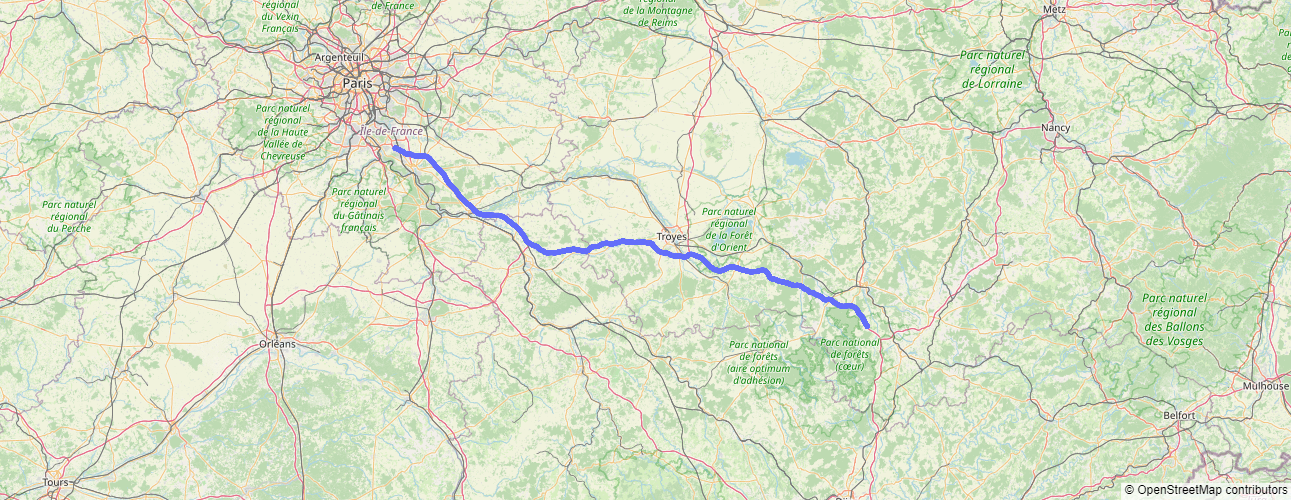

In [159]:
fig = px.scatter_mapbox(dfgps, lat='lat', lon='lng', zoom=7)

fig.update_layout(
    mapbox_style="open-street-map",
    margin={'r':0,'t':0,'l':0,'b':0},
    height=500,width=800
)

fig.show()

**API to get the elevation of each (longitude, latitude) GPS point**
<br> <br>
Example of API use:
<br>
https://wxs.ign.fr/calcul/alti/rest/elevation.json?lon=0.2367|2.1570&lat=48.0551|46.6077&zonly=true

Getting the elevation for each point

In [160]:
# Use an API to find the elevation of each time juste in the first time, if we run the Notebook again, we will avoid this step
First_time= False

if First_time:

    # Initialize an empty list to store elevation values
    elev_list = []

    # Iterate through the data in steps of 20
    for i in range(0, len(dfgps), 20):
        # Extract longitude and latitude values for the current chunk
        lons = dfgps.iloc[i:i+20, :].lng.values
        lats = dfgps.iloc[i:i+20, :].lat.values

        # Convert the lists of longitude and latitude values to pipe-separated strings
        lons = '|'.join([str(x) for x in lons])
        lats = '|'.join([str(x) for x in lats])

        # Construct the URL for elevation data using IGN's API
        url = 'https://wxs.ign.fr/calcul/alti/rest/elevation.json?lon=' + lons + '&lat=' + lats + '&zonly=true'

        # Make a request to the API and retrieve elevation data
        result = requests.get(url)
        elevations = result.json()['elevations']

        # Append the elevation values to the elev_list
        elev_list += elevations

        # Print progress (overwriting the line)
        print(f'\r{i}', end='', flush=True)
        
    # Add the elevation column to the DF: 
    dfgps['elev']=elev_list
    # The elevation API is very slow, so we will save the DataFrame as parquet format to avoid waiting this API each time
    dfgps.to_parquet(r'../data/processed/dfgps_V0.gzip',compression='gzip') 

else:
    # Read the dataFrame with the elevation to avoid waiting this API each time as the Notebook as run again
    dfgps=pd.read_parquet(r'../data/processed/dfgps_V0.gzip')

In [161]:
dfgps.head(3)

lng       lat   elev
0  2.553051  48.61510  89.10
1  2.553110  48.61519  89.18
2  2.553130  48.61523  89.10

In [162]:
dfgps.dtypes

lng     float64
lat     float64
elev    float64
dtype: object

**Distance between each two successive points: 2D methode**

In [163]:
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculates the great-circle distance (haversine) between two points on Earth's surface.
    
    Args:
        lat1 (float): Latitude of the first point in degrees.
        lon1 (float): Longitude of the first point in degrees.
        lat2 (float): Latitude of the second point in degrees.
        lon2 (float): Longitude of the second point in degrees.
    
    Returns:
        float: Distance between the two points in meters.
    """
    R = 6371e3  # Radius of the Earth in meters (mean radius)
     
    # Convert latitude and longitude differences to radians
    dlat = (lat2 - lat1) * np.pi / 180
    dlon = (lon2 - lon1) * np.pi / 180
    
    # Haversine formula
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    # Calculate the distance
    return R * c

In [164]:
# Assuming dfgps is your DataFrame and it has columns 'lat' and 'lon'
dfgps['lat_shifted'] = dfgps['lat'].shift(1)
dfgps['lon_shifted'] = dfgps['lng'].shift(1)

# Apply the haversine function to each row
dfgps['distance'] = dfgps.apply(lambda row: haversine(row['lat'], row['lng'],\
                                row['lat_shifted'], row['lon_shifted']), axis=1)

# Initialise the distance with 0
dfgps['distance'].iloc[0]=0

In [165]:
# Drop the shifted columns
dfgps.drop(['lat_shifted','lon_shifted'],axis=1,inplace=True)
dfgps.head(3)

lng       lat   elev  distance
0  2.553051  48.61510  89.10  0.000000
1  2.553110  48.61519  89.18  9.976786
2  2.553130  48.61523  89.10  4.451300

**The minimum distance between two neighboring points**

In [166]:
# km/h to m/s
mps=(140/3.6) 
# the desired minimum time between two rows
dtmin=1 # seconds
# Calcul of the minimum distance 
dist_min=int(mps/dtmin)
print('the min distance between 2 neighboring point to have time min of',dtmin,'seconde is',dist_min,'m')

the min distance between 2 neighboring point to have time min of 1 seconde is 38 m


**Drop the closest points**

In [167]:
# Initial length of the dfgps
Ni=len(dfgps)

# Drop the closest point if the distance between each successive points is under the minimum dist
for i in dfgps.index[1:]:
    if dfgps.loc[i,'distance'] < dist_min:
        dfgps.drop(i,axis=0,inplace=True)

In [168]:
print('Initial length of the dfgps:',Ni,'After droping the closest points:',len(dfgps))

Initial length of the dfgps: 11636 After droping the closest points: 538


In [169]:
# Calculate the cumulative sum of the distance 
dfgps['dist_cum']=dfgps.distance.cumsum()

In [170]:
# Display the head and tails of the DF
dfgps.iloc[[0,1,3,-3,-2,-1],:]

lng       lat    elev   distance      dist_cum
0      2.553051  48.61510   89.10   0.000000      0.000000
6      2.553730  48.61622   89.28  40.076285     40.076285
97     2.574020  48.61046   94.63  70.515530    150.328039
11563  5.139970  47.97233  407.16  43.767043  31373.911140
11564  5.140240  47.97201  407.98  40.746223  31414.657363
11578  5.141730  47.97029  410.82  39.798272  31454.455635

the total distance is **166.9km**, and we know from google maps that the distance is close to **225km**, the error is caused by the distance calculation without elevation.
<br>
Let's verify this hypothesis by the 3D calculation below:

**Distance between each two successive points: 3D methode**

In [171]:
def haversine3D(lat1, lon1, elev1, lat2, lon2, elev2):
    """
    Calculates the great-circle distance (haversine) between two points on Earth's surface.

    Args:
        lat1 (float): Latitude of the first point in degrees.
        lon1 (float): Longitude of the first point in degrees.
        elev1 (float): Elevation of the first point in meters.
        lat2 (float): Latitude of the second point in degrees.
        lon2 (float): Longitude of the second point in degrees.
        elev2 (float): Elevation of the second point in meters.

    Returns:
        float: Delta distance between the two points in meters.
    """
    R = 6371e3  # Radius of the Earth in meters (mean radius)

    # Convert latitude and longitude differences to radians
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)

    # Haversine formula
    a = math.sin(dlat / 2) ** 2 + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Calculate the 2D distance
    dist_2d = R * c

    # Calculate the 3D distance (including elevation)
    delta_elev = abs(elev2 - elev1)
    dist_3d = math.sqrt(dist_2d ** 2 + delta_elev ** 2)

    return dist_3d

In [172]:
# conserve only the lat, lng and elev columns
dfgps=dfgps[['lat','lng','elev']].reset_index(drop=True)

In [173]:
# Assuming dfgps is your DataFrame and it has columns 'lat' and 'lon'
dfgps['lat_shifted'] = dfgps['lat'].shift(1)
dfgps['lon_shifted'] = dfgps['lng'].shift(1)
dfgps['elev_shifted'] = dfgps['elev'].shift(1)

# Apply the haversine function to each row
dfgps['distance'] = dfgps.apply(lambda row: haversine3D(row['lat'], row['lng'],\
                    row['elev'],row['lat_shifted'], row['lon_shifted'], \
                                                row['elev_shifted']), axis=1)

# Initialise the distance with 0
dfgps['distance'].iloc[0]=0

# Drop the shifted columns
dfgps.drop(['lat_shifted','lon_shifted','elev_shifted'],axis=1,inplace=True)

# Calculate the cumulative sum of the distance 
dfgps['dist_cum']=dfgps.distance.cumsum()

# Display the head and tails of the DF
dfgps.iloc[[0,1,3,-3,-2,-1],:]

lat       lng    elev    distance       dist_cum
0    48.61510  2.553051   89.10    0.000000       0.000000
1    48.61622  2.553730   89.28  134.133031     134.133031
3    48.61046  2.574020   94.63  635.524981    1766.041049
535  47.97233  5.139970  407.16   55.188408  220479.167345
536  47.97201  5.140240  407.98   40.875221  220520.042566
537  47.97029  5.141730  410.82  221.112512  220741.155078

Now the total distance is **225 km**, the same as the google maps, so our first hypothesis is verified

In [174]:
dfgps.distance.iloc[1:].min()

38.21631956319751

**Speed profile**

In [175]:
# The speed profile in the file "highway_A5_speed.csv" is maded manually 
df_speed_A5=pd.read_csv('../data/raw/highway_A5_speed.csv')
dis=df_speed_A5.distance.values
speed=df_speed_A5.kmph.values

display(df_speed_A5.tail(3))

distance        kmph
35  225053.179491  109.413854
36  225186.651795    0.000000
37  225189.000000    0.000000

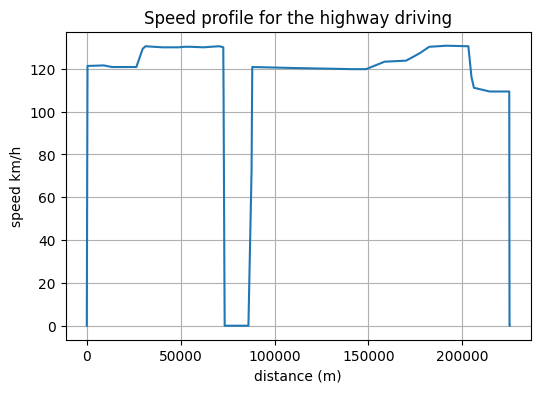

In [176]:
#Plot 

figure(figsize=(6,4))
plt.plot(dis,speed)
plt.xlabel('distance (m)')
plt.ylabel('speed km/h')
plt.grid()
plt.title('Speed profile for the highway driving')
plt.show()

In [177]:
print('length of df_speed_A5 is:',len(df_speed_A5),', and the length of dfgps is:',len(dfgps))

length of df_speed_A5 is: 38 , and the length of dfgps is: 538


As we can see above, the length of the gps DataFrame is more than the length of the speed curve profile, so we will use interpolation to generate new speed with the same length as the "dfgps"

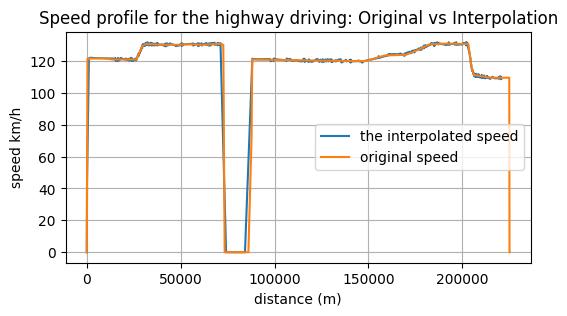

In [178]:
# x , y of interpolation
dis=np.array(dis)
speed=np.array(speed)

# The interpolation function 
f = interpolate.interp1d(dis, speed)

# The ne x "distances"
new_dis = dfgps.dist_cum.values 

# Interpolation of the speed 
new_speed = f(new_dis) 

# add a random noise with +/-1km/h to the new speed 
new_speed =new_speed + np.random.uniform(-1,1,len(new_dis)) 

# Avoid negative speed
new_speed[new_speed<2]=0

# check the original speed and the interpolated speed 
# Plot 
figure(figsize=(6,3))
plt.plot(new_dis,new_speed, label='the interpolated speed')
plt.plot(dis,speed, label='original speed')

plt.xlabel('distance (m)')
plt.ylabel('speed km/h')
plt.grid()
plt.legend()
plt.title('Speed profile for the highway driving: Original vs Interpolation')
plt.show()

Add the speed to the dfgps 

In [179]:
dfgps['kmph']=new_speed
dfgps.head(2)

lat       lng   elev    distance    dist_cum       kmph
0  48.61510  2.553051  89.10    0.000000    0.000000   0.000000
1  48.61622  2.553730  89.28  134.133031  134.133031  44.331355

### Time row

**Get the time from the distance and the speed**

In [180]:
dt=dfgps.distance/(dfgps.kmph/3.6)
dt.iloc[0]=dt.mean()
print('The minimum delta time is',format(dt.min(),'.2f'),'s > 1s')

The minimum delta time is 1.17 s > 1s


In [181]:
# whene the speed is 0 the calculated time is inf
dt.replace([np.inf, -np.inf], np.nan,inplace=True)
# replace inf by the mean time 
dt[dt.isna()]=dt.mean()
# Initialise the beginning with 1s
dt.iloc[0]=1

Check the delta Time variable 

In [182]:
dt.describe()

count    538.000000
mean      11.865716
std       24.498468
min        1.000000
25%        2.542123
50%        4.234350
75%       11.476762
max      301.813693
dtype: float64

Add the delta time to the dataframe

In [183]:
dfgps['dt']=dt

Calculate the time by the cumulative sum of delta time

In [184]:
dfgps['time']=dfgps['dt'].cumsum()

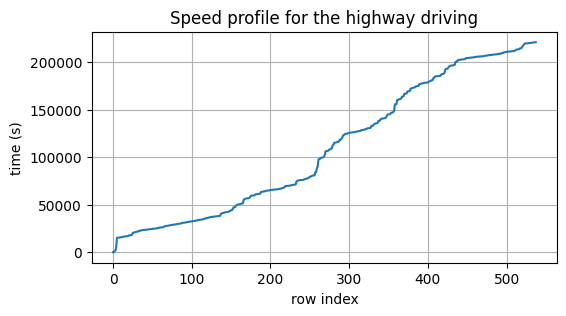

In [185]:
figure(figsize=(6,3))
plt.plot(dfgps.dist_cum)
plt.xlabel('row index')
plt.ylabel('time (s)')
plt.grid()
plt.title('Speed profile for the highway driving')
plt.show()

**Save the df with the time**

In [187]:
dfgps.to_parquet(r'../data/processed/dfgps_V1.gzip',compression='gzip') 

### The road gradient

**read the dataframe**

In [188]:
dfgps=pd.read_parquet(r'../data/processed/dfgps_V1.gzip')

In [189]:
dfgps.head(2)

lat       lng   elev    distance    dist_cum       kmph         dt   
0  48.61510  2.553051  89.10    0.000000    0.000000   0.000000   1.000000  \
1  48.61622  2.553730  89.28  134.133031  134.133031  44.331355  10.892492   

        time  
0   1.000000  
1  11.892492

**Road gradient in % and degree**

In [190]:
# delta distance
dx=dfgps.dist_cum-dfgps.dist_cum.shift(1)
# delta elevation
dz=dfgps.elev-dfgps.elev.shift(1)
# road gradient in percentage
rouad_grad_100=100*dz/dx
# road gradient in degree with arctan formula
rouad_grad_deg=(180/np.pi)*np.arctan(rouad_grad_100/100) # "(180/np.pi)" convert the gradient to degree

Plot the road grad 

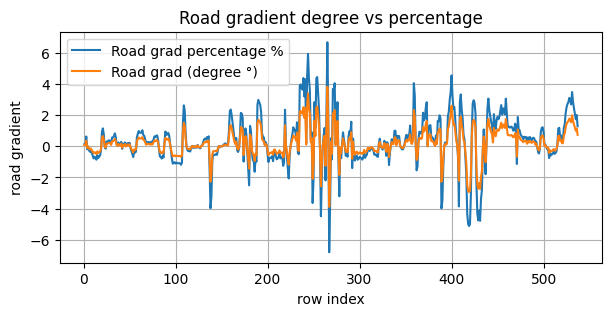

In [191]:
figure(figsize=(7,3))
plt.plot(rouad_grad_100,label='Road grad percentage %')
plt.plot(rouad_grad_deg,label='Road grad (degree °)')
plt.xlabel('row index')
plt.ylabel('road gradient')
plt.grid()
plt.legend()
plt.title('Road gradient degree vs percentage')
plt.show()

The max of road gradient % is around 7,this is because the no accuracy elevation, but we know that the max value in this highway is around 3.5 - 4% (see the link below), so we propose to use the rolling mean to filter the road grad

https://routes.fandom.com/wiki/Sections_autorouti%C3%A8res_%C3%A0_fortes_pentes

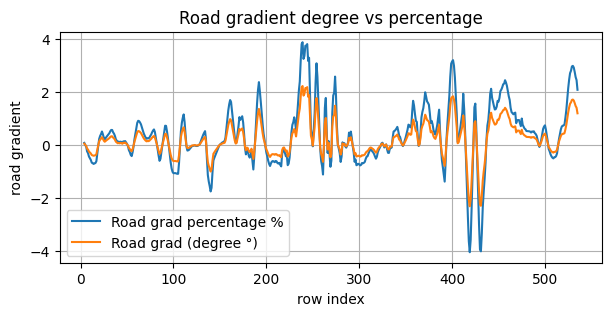

In [192]:
rouad_grad_100_f=rouad_grad_100.rolling(6,center=True).mean()
rouad_grad_deg_f=rouad_grad_deg.rolling(6,center=True).mean()

# Plot
figure(figsize=(7,3))
plt.plot(rouad_grad_100_f,label='Road grad percentage %')
plt.plot(rouad_grad_deg_f,label='Road grad (degree °)')
plt.xlabel('row index')
plt.ylabel('road gradient')
plt.grid()
plt.legend()
plt.title('Road gradient degree vs percentage')
plt.show()

**Plmot the road gradient and elevation**

In [193]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [194]:
dfplot=dfgps.copy()
dfplot['rouad_grad_100_f']=rouad_grad_100_f
dfplot['rouad_grad_deg_f']=rouad_grad_deg
dfplot.dropna(inplace=True)

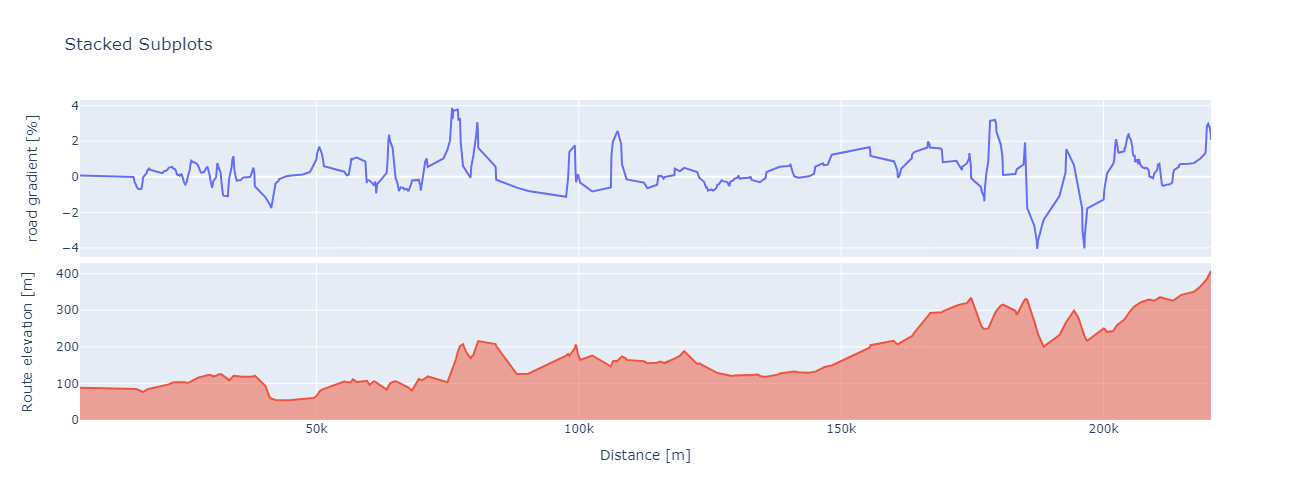

In [195]:
fig = make_subplots(rows=2, cols=1,  shared_xaxes=True,
        vertical_spacing=0.02,
        horizontal_spacing=0.0)

fig.append_trace(go.Scatter(
        x=dfplot.dist_cum,
        y=dfplot.rouad_grad_100_f,name='Rouad Grad' ,
        text=dfplot[['rouad_grad_100_f', 'elev' ]]
        ,hovertemplate=' %{y:.2f} , Elevation= %{text[1]}' # :.2f, 2 decimal digits
        ), 
            row=1, col=1)

fig.append_trace(go.Scatter(
        x=dfplot.dist_cum,
        y=dfplot.elev,
        name='Elevqtion',
        text=dfplot[['rouad_grad_100_f', 'elev' ]]
        ,hovertemplate='%{y} , Rouad Grad= %{text[0]:.2f}' , 
        stackgroup='one'), 
            row=2, col=1)

fig.update_traces(xaxis="x2")

# Update y/xaxis properties
fig.update_yaxes(title_text='road gradient [%]', row=1, col=1)
fig.update_yaxes(title_text='Route elevation [m]', row=2, col=1)
fig.update_xaxes(title_text="Distance [m]", row=2, col=1)

fig.update_layout(height=500, width=800, title_text="Stacked Subplots",
                  hovermode="x unified",  # Set hovermode to 'x unified'
                  showlegend=False)
fig.show()

Head and tails of the final dataFrame

In [196]:
dfplot[['time','lng', 'lat', 'elev','dist_cum', 'kmph','rouad_grad_deg_f']].iloc[[0,1,-2,-1],:]

time      lng       lat    elev       dist_cum        kmph   
4     154.293067  2.61141  48.59605   88.45    4948.178223  121.694552  \
5     456.106761  2.74626  48.57555   87.08   15125.653608  121.395789   
534  6373.268725  5.13960  47.97276  406.20  220423.978937  108.712309   
535  6375.085453  5.13997  47.97233  407.16  220479.167345  109.360511   

     rouad_grad_deg_f  
4           -0.111273  
5           -0.007713  
534          1.212880  
535          0.996557

**Save the final DataFrame as csv file**

In [197]:
dfplot[['time','lng', 'lat', 'elev','dist_cum', 'kmph','rouad_grad_deg_f']].to_csv('../data/processed/dfgps_fin.csv')

# Matlab / Simulink

## Newton's second law

The figure below show the forces applied to the vehicle

<img src='../otherFiles/car_img.png'>

The Newton's second law applied to the vehicle: see above (X-axis projection)
 
$$
\begin{align*}
 F_x &= m \frac{dv}{dt}= Thrust - (Drag + m.g.sin(α) + Rolling)\\
& with: Thrust = Torque . wheelRadius
\end{align*}
$$


## Simulation hypotheses

For this project, the simulation will be simplified with the below hypothesis:
* All information about the vehicle specification will be gathered from internet: see the links below
* The only inertia of the vehicle is its weight, so we negligee all rotated parte inertias, the inertia of electronic components like the motor winding inductances...
* The motor is controlled with a sample low: max torque utile the power = power max, after that we will adapt max power until the max speed
* The inverter, mechanical reductor, are modeled with a sample efficient confession
* The Coriolis force is negligee
* The gravitational acceleration "g" and earth's radius are constants
* battery cells are assumed to be perfectly balanced
* The drag coefficient will be tuned to find a WLTC autonomy close to Renault official specification
* the wheels are supposed to roll without slipping

## Simulink

### Initialisation

Below the simulation file used fot the highway driving [Init_ParisA5_225km.m](https://github.com/bouz1/EV_Matlab_Simulink_Megane_E_TECH_to_generate_data/blob/main/matlabFiles/ParisA5_225km/Init_ParisA5_225km.m)
<br> 
You can find the explanation and the source of the information in the comment of each parameter
_______________________________________________________________________

%% Clear all variables %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%<br>clear all; <br>%% %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%<br><br><br><br>%% General variables %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%<br>torque_max=300; %% N.m %% https://www.autodauphine.fr/uploads/vehicules_neufs/44/1641221181_ddc90a41141d81d0c5f3.pdf<br>power_max = 160e3; %% W %% https://www.autodauphine.fr/uploads/vehicules_neufs/44/1641221181_ddc90a41141d81d0c5f3.pdf<br>m = 1600+80*2; %% %% weight of the vehicle + 2 average persones [kg] https://www.renault.fr/vehicules-electriques/megane-e-tech-electrique/comparateur-specifications.html<br>m0= 1600; %% Vehicle without passangers<br>g = 9.80665 ; %% %% standard gravitational acceleration for the surface of the Earth [m/s2]<br>mps_to_kmph= 3.6; %% V[km/h]  = V[m/s] * mps_to_kmph <br><br><br>%% Drag %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%<br>air_density=1.293 ; %% kg m?3 %% air density <br>SCx= 0.674 ; %% [m²] %% https://www.lesnumeriques.com/voiture/renault-megane-e-tech-electric-la-nouvelle-compacte-electrique-aux-faux-airs-de-suv-n167917.html<br>%%%The above measurement give a SCx of 0.674<br>%%%But the idea is to tune the SCx to find an WLTC autonomy between 450 and 470km<br>SCx= 0.5; %% with this value the autonomy is 457km => OK <br>k_drag= (1/2)*air_density*SCx; %% N/(m/s)^2 %% drag total coefficient: Drag = k_drag * velocity ^2 https://en.wikipedia.org/wiki/Drag_equation<br><br><br><br>%% Rolling %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%<br>% formula Rolling = f · m · g · cos(?) https://x-engineer.org/rolling-resistance/<br>% f : rolling resistance coefficient = 0.013 https://x-engineer.org/rolling-resistance/<br>% ? : road with the gradient [rad]<br>% m: weight of the vehicle [kg] : see above<br>% k_rolling = f · m · g<br>k_rolling = 0.013*m*g; %% total rolling coefficient : Rolling = k_rolling· cos(?) see above <br><br><br><br><br>%% Reduction ratio %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%<br>kmph_max=160; %% [km/h] %% max speed: https://fr.wikipedia.org/wiki/Renault_Megane_E-Tech_Electric<br>rpm_max=11688;%% [tr/min]%% max rpm: https://fr.wikipedia.org/wiki/Renault_Megane_E-Tech_Electric<br>rmp_2_kmph=(kmph_max/rpm_max);%% V[km/h]= rmp_2_kmph* N[tr/min]<br>tourque_2_thrust = (2*pi*3.6/60)/rmp_2_kmph; %% Thrust [N] = tourque_2_thrust * Torque[N.m]<br><br>%% Efficiency<br>motor_eff=0.91  ; %% https://renault.com.mt/driveelectric/engine-e-tech-electric.html#:~:text=Our%20externally%20excited%20synchronous%20motor,a%20high%20performance%20of%2091%25.<br>inverter_eff = 0.93 ; %% example of inverter efficiency : https://www.powersystemsdesign.com/articles/efficient-dc-ac-inverter-for-high-voltage-electric-vehicles/95/15405<br>reduction_eff=0.98;  %% I don't find any value in the web, but a chose this value because reductor will be effcient <br><br><br>%% Inverter %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%<br>U_uvp = 330 ; %% V %% the under voltage protaction<br><br><br>%% Battery %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%<br>Nb_modules= 12; %% https://www.renaultgroup.com/wp-content/uploads/2023/03/renault_deu_20230316.pdf<br>Nb_cells_by_modules= 24;%% https://www.renaultgroup.com/wp-content/uploads/2023/03/renault_deu_20230316.pdf<br>Nb_cells= Nb_modules*Nb_cells_by_modules;<br>Nb_cells_paralles = floor(Nb_cells*4.2/400); % voltage of cell = 4.2V <===> 400v of the batterie <br>Nb_serial= Nb_cells/Nb_cells_paralles; % Nb of serial cells<br>soc = [0, 2, 6, 9, 20, 37, 42, 57, 66, 77, 85, 91, 95, 98, 100]; %% State of charge   : https://www.richtek.com/Design%20Support/Technical%20Document/AN024<br>U_cell=[3.41, 3.61, 3.78, 3.86, 3.89, 3.90, 3.92, 3.97, 4.00, 4.04, 4.10, 4.16, 4.19, 4.195, 4.20]; %% cell voltage   : https://www.richtek.com/Design%20Support/Technical%20Document/AN024<br>U_bat= U_cell*Nb_serial; %% the battery voltage<br>bat_energy_kwh= 60 ; %% kWh %% the battery capacity 60kWh:  https://fr.wikipedia.org/wiki/Renault_Megane_E-Tech_Electric<br>bat_energy=bat_energy_kwh*1000*3600 ;%% W.s = j %%<br>R_dc=0.25 ; %% Ohm %% internal batterie resistnace <br><br><br><br>%% Speed controlor (PI) %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%<br>K_p= 0.05;%% 0.03<br>w_I= 0.01; %% 0.01  0.005<br>P_coef= K_p;<br>I_coef = K_p*w_I;<br><br><br>%% WLTC Data %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% <br>% you can find the pdf in this link https://en.wikipedia.org/wiki/Worldwide_Harmonised_Light_Vehicles_Test_Procedure<br>data= readtable('../../data/processed/dfgps_fin.csv');<br>time= data.time; <br>kmph= data.kmph; <br>sim_time=max(time); %%% sim time <br>rouad_grad=data.rouad_grad_deg_f %% Road gradient<br>Ts= 0.5; %% Simulation step<br>PWr= power_max/m0; %% = 100 W/kg > 34 ==> class 3 of WLTC ; The power-to-mass ratio (PWr) Pwr = Power[w]/masse[kg]<br><br>%% Plot WLTC time/kmph<br>plot(time,kmph);<br><br><br>%% Initial values<br>x_initial=0 ; %%m%% initial distance <br>Velocity_0= 0; %% Initial vehicle speed

__________

### Simulation blocks

You can find all simulink pdf printing in the [link](https://github.com/bouz1/EV_Matlab_Simulink_Megane_E_TECH_to_generate_data/tree/main/matlabFiles/Prints)
<br> for example this [link is the pdf of the highway driving in the A5](https://github.com/bouz1/EV_Matlab_Simulink_Megane_E_TECH_to_generate_data/blob/main/matlabFiles/Prints/MEGANE_E_TECH_EV60_220_ParisA5_225km.pdf) 
<br><br> Below an example of the main block sheet, we can check the above link to see the details of all subsystem like "vehicle", "speed control" ...

<img src='https://bouz1.github.io/fils/MEGAN_ETECH_220/Main_Simulink_A5.PNG'>
